# Connect with google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import json

# update your path for samples.json file
sample_key_path = '/content/drive/MyDrive/Colab Notebooks/resnet18-v5-finetune/samples.json'
# Open and read the JSON file. Make sure the same laoding sequence of samples as the paper
with open(sample_key_path, 'r') as f:
    data = json.load(f)

# Print the dictionary to see its content
print(data)

{'IPP_10__4_0.56_0.837_0.657': 0, 'IPP_30__2_2.16_1.02_0.7049': 1, 'IPP_5__6_0.88_1.241_0.456': 2, 'IPP_5__8_0.97_1.399_0.613': 3, 'R_7_IPP_20__3_3.05_1.114_1.105': 4, 'IPP_40__5_3.56_1.4734_0.872': 5, 'R_1_IPP_20__3_0.8_1.027_1.2': 6, 'R_1_IPP_30__4_2.32_1.562_1.23': 7, 'R_7_IPP_20__5_1.91_1.628_1.082': 8, 'R_10_IPP_20__1_3.44_1.481_1.300': 9, 'R_2_IPP_10__4_0.87_1.526_1.034': 10, 'R_2_IPP_5__6_0.81_1.307_0.794': 11, 'R_1_IPP_10__4_0.39_1.014_0.6422': 12, 'R_1_IPP_20__5_1.89_1.144_1.412': 13, 'R_1_IPP_40__1_4.98_1.411_2.106': 14, 'R_5_IPP_20__1_1.638_1.397_0.955': 15, 'R_10_IPP_20__3_4.46_1.472_1.4132': 16, 'R_2_IPP_40__5_3.39_1.485_1.536': 17, 'R_2_IPP_20__5_1.29_1.313_1.276': 18, 'R_5_IPP_20__5_1.29_1.420_0.769': 19, 'IPP_20__5_1.67_1.423_0.648': 20, 'R_1_IPP_30__2_1.7_1.523_1.423': 21, 'R_2_IPP_20__3_2.17_1.578_1.173': 22, 'R_2_IPP_30__3_4.1_2.113_1.408': 23, 'IPP_5__4_0.44_1.403_0.245': 24, 'R_10_IPP_20__2_2.35_1.354_1.18': 25}


#Load data and make groups according to UTS value and each sample. This groups is for later using StratifiedGroupKFold from sklearn_model_selection:


In [6]:
import os
import gc
import pandas as pd
from PIL import Image
from torchvision.transforms import transforms
import random

from torchvision.transforms import ToPILImage
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from IPython.display import display

import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
from sklearn.model_selection import KFold


import torch
import numpy as np
import random
from sklearn.metrics import r2_score
from sklearn.model_selection import StratifiedGroupKFold
import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, models
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
# from ax.service.managed_loop import optimize

# Check if CUDA (GPU) is available
cuda_device = 'cuda'  # most people use cuda:0 so let's try to use the other GPU on the machine
device = torch.device(cuda_device if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Define the image transforms
image_transforms = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # transforms.RandomAutocontrast(p=1.0),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


class CustomDatasetV5(torch.utils.data.Dataset):
    def __init__(self, data, device='cpu'):
        self.data = data
        self.device = device
        self.preload_to_device()

    def preload_to_device(self):
        self.data = [(image.to(self.device), group, torch.tensor(label).float().to(self.device),
                      torch.tensor(features).float().to(self.device),name) for image, group, label, features, name in self.data]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image, group, label, features, name = self.data[index]
        return image, group, label, features,name


def make_dataset_v5(data_folder, N=1, train_data= True, verbose=False):

    # Set the random seed
    random.seed(16)

    # Create a list to store the data tuples
    this_data = []

    # Get a list of subfolders in the data folder
    subfolders = os.listdir(data_folder)
    # sample_keys = {k: i for i, k in enumerate(subfolders)}
    if train_data:
        sample_keys = data
    else:
        sample_keys = {k: i for i, k in enumerate(subfolders)}

    # Sort subfolders based on the index after splitting by '_', and [-3] represent the UTS
    subfolders.sort(key=lambda x: float(x.split('_')[-3]))

    # Group subfolders based on i % 5
    grouped_subfolders = [[] for _ in range(5)]
    for i, subfolder in enumerate(subfolders):
        index = i // (len(subfolders)//5)
        if index >=5:
            index -= 1
        grouped_subfolders[index].append(subfolder)
    if verbose:
        print(grouped_subfolders)

    chunk_keys = {}
    for i, gs in enumerate(grouped_subfolders):
        for sf in gs:
            chunk_keys[sf] = i

    # Randomly select one subfolder from each group
    for _ in range(len(subfolders) // 5 +1):
        for k, group in enumerate(grouped_subfolders):
            if group:
                selected_subfolder = random.choice(group)
                group.remove(selected_subfolder)
                folder_path = os.path.join(data_folder, selected_subfolder)

                # Load the CSV data
                csv_data = None
                for file_name in os.listdir(folder_path):
                    if file_name.endswith(".csv"):
                        csv_path = os.path.join(folder_path, file_name)
                        csv_data = pd.read_csv(csv_path)
                        break

                # Load the image data and combine it with the CSV data
                num = 0
                image_names = [image_name for image_name in os.listdir(folder_path) if image_name.endswith(".jpg")]
                image_names.sort()
                # Select every fifth image
                for i, image_name in enumerate(image_names):
                    if i % N != 0:
                        continue
                    num+=1
                    # print(image_name)
                    image_path = os.path.join(folder_path, image_name)
                    image_data = Image.open(image_path).convert("RGB")  # Convert image to RGB mode
                    image_data = image_transforms(image_data)

                    # Find the corresponding row in the CSV data
                    if csv_data is not None:
                        image_index = csv_data[csv_data["Image Name"] == image_name].index[0]
                        image_features = csv_data.iloc[image_index, 1:].values.astype(float)
                        image_label = csv_data.loc[csv_data["Image Name"] == image_name, "UTS (MPa)"].values[0].astype(float)
                    else:
                        image_features = None

                    # print(selected_subfolder, (chunk_keys[selected_subfolder], sample_keys[selected_subfolder]))
                    # Add data to the list
                    this_data.append((image_data, (chunk_keys[selected_subfolder], sample_keys[selected_subfolder]), image_label, image_features, image_name))
                if verbose:
                    print(f'Number of images in folder {selected_subfolder}: {num}')

    return CustomDatasetV5(this_data, device= device)

Using device: cpu


In [7]:
N_skip = 1
TRAIN_VAL_PATH = "/content/drive/MyDrive/Images/Train_val"
train_val_dataset = make_dataset_v5(TRAIN_VAL_PATH, N=N_skip,train_data= True, verbose=False)
TEST_PATH = "/content/drive/MyDrive/Images/Test"
test_dataset = make_dataset_v5(TEST_PATH, N=N_skip, train_data= False, verbose=False)

# Load pre-trained models (resnet18-v5). Plot Parity Violin Plot

Using device: cpu
Fold 1/5
Loading saved outputs for this fold.
Loaded unique validation groups: [0 1 2 3 4]
Loaded unique sample IDs: [ 0  5 10 20 22]
Validation groups for fold 1 contains unique UTS: [0.56, 0.87, 1.67, 2.17, 3.56]
MSE: Train: 0.4992836117744446, Validation: 0.1986047923564911, Test: 0.141069695353508


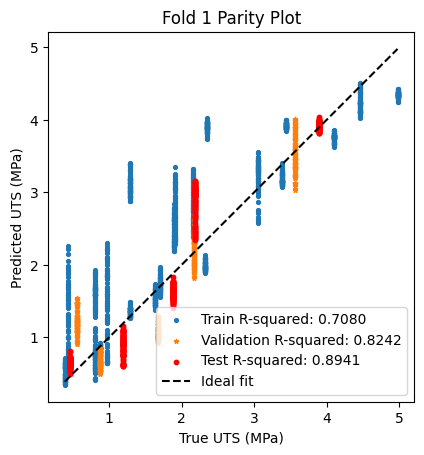

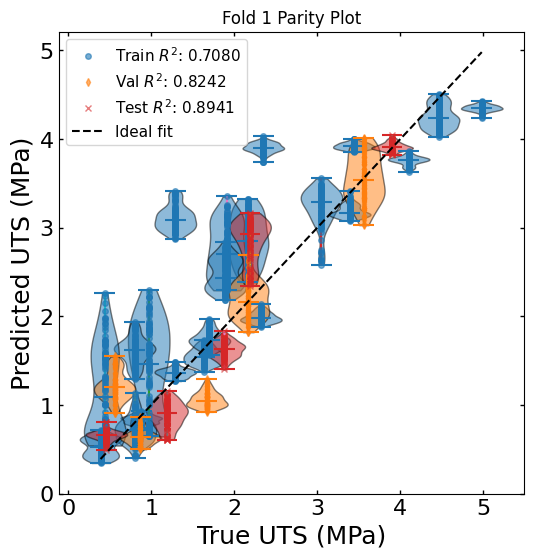

Fold 2/5
Loading saved outputs for this fold.
Loaded unique validation groups: [0 1 2 3 4]
Loaded unique sample IDs: [ 1  8 11 14 19]
Validation groups for fold 2 contains unique UTS: [0.81, 1.29, 1.91, 2.16, 4.98]
MSE: Train: 0.11692417412996292, Validation: 0.4263521432876587, Test: 0.176996648311615


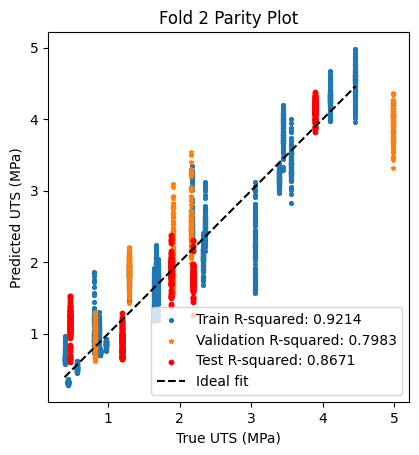

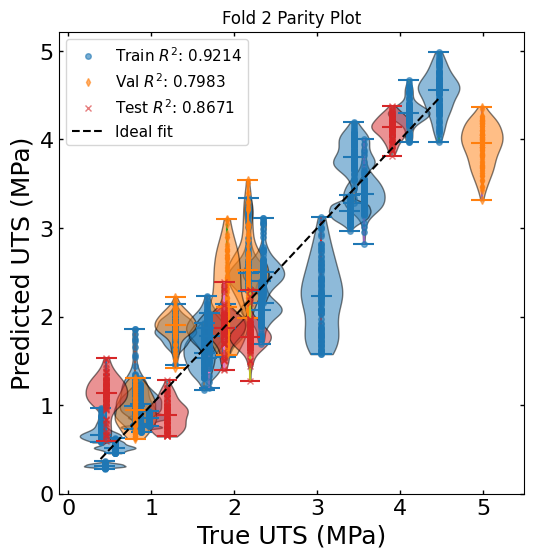

Fold 3/5
Loading saved outputs for this fold.
Loaded unique validation groups: [0 1 2 3 4]
Loaded unique sample IDs: [ 2  7 12 16 21]
Validation groups for fold 3 contains unique UTS: [0.39, 0.88, 1.7, 2.32, 4.46]
MSE: Train: 0.12945674359798431, Validation: 0.3137674629688263, Test: 0.3209645450115204


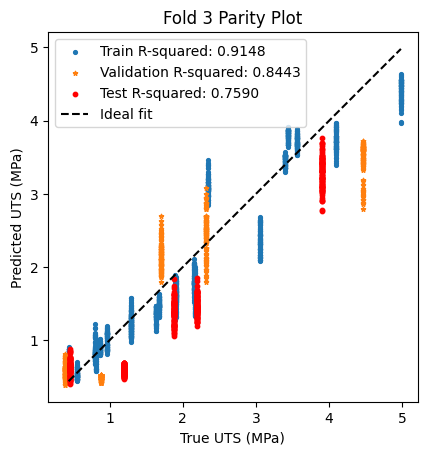

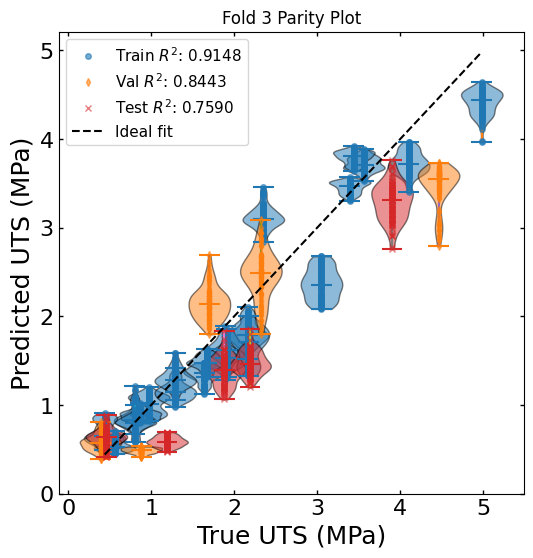

Fold 4/5
Loading saved outputs for this fold.
Loaded unique validation groups: [0 1 2 3 4]
Loaded unique sample IDs: [ 3  6 13 17 23 25]
Validation groups for fold 4 contains unique UTS: [0.8, 0.97, 1.89, 2.35, 3.39, 4.1]
MSE: Train: 0.07700890302658081, Validation: 0.2985748052597046, Test: 0.11420822888612747


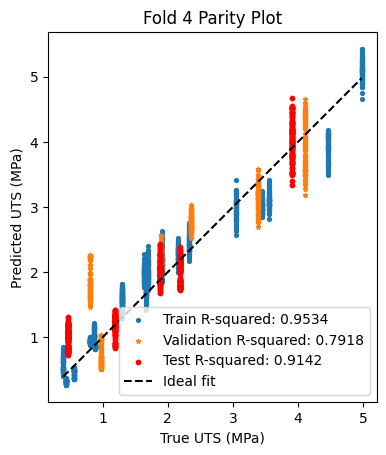

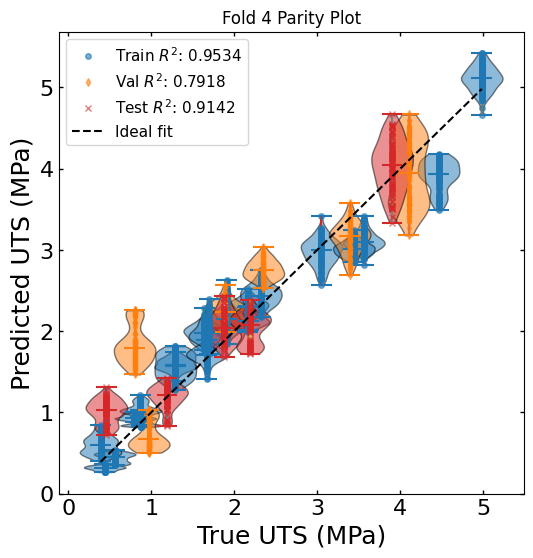

Fold 5/5
Loading saved outputs for this fold.
Loaded unique validation groups: [0 1 2 3 4]
Loaded unique sample IDs: [ 4  9 15 18 24]
Validation groups for fold 5 contains unique UTS: [0.44, 1.29, 1.638, 3.05, 3.44]
MSE: Train: 0.23760297894477844, Validation: 0.4584656357765198, Test: 0.16008275747299194


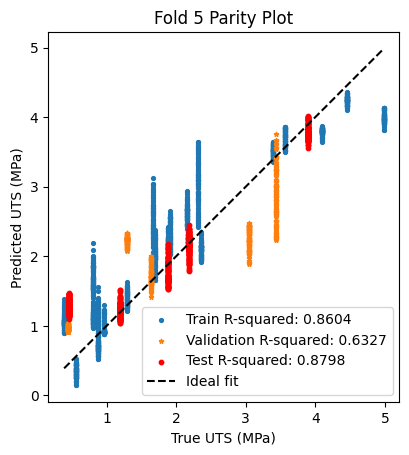

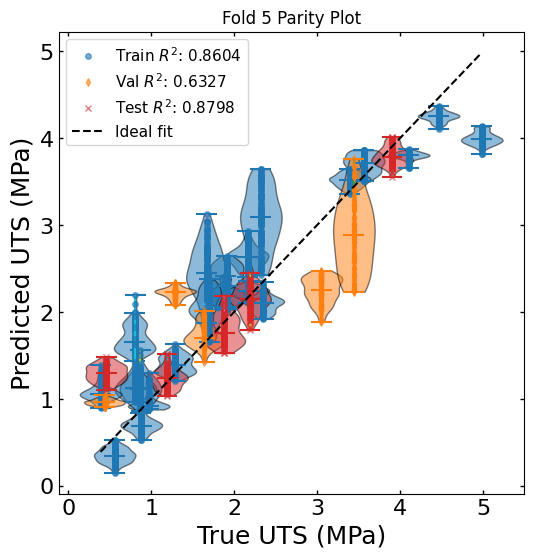

Final Statistics Across All Folds:
Train MSE: 0.2121 ± 0.1531
Train R-squared: 0.8716 ± 0.0871
Validation MSE: 0.3392 ± 0.0937
Validation R-squared: 0.7783 ± 0.0752
Test MSE: 0.1827 ± 0.0722
Test R-squared: 0.8629 ± 0.0542


In [8]:
import torch
import numpy as np
import random
from sklearn.metrics import r2_score, mean_squared_error
import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms, models
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedGroupKFold
from PIL import Image
import os

meta_learner_results = {}

# Set seeds for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

# Check if CUDA (GPU) is available
cuda_device = 'cuda:1'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Define the image transforms
Resize = (256, 256)  # Define your Resize dimensions
online_transforms = transforms.Compose([
    transforms.Resize(Resize),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_xform_list = [transforms.CenterCrop(224)]
params = {}
params['use_contrast'] = False
if params['use_contrast']:
    val_xform_list.append(transforms.RandomAutocontrast(p=1.0))
val_xform_list.append(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
offline_transforms = transforms.Compose(val_xform_list)

# Initialize lists to store R-squared and MSE for each fold
train_rsquared_all_fold = []
val_rsquared_all_fold = []
test_rsquared_all_fold = []

train_mse_all_fold = []
val_mse_all_fold = []
test_mse_all_fold = []

test_preds_history = []

# Initialize KFold object
n_splits = 5
kf = StratifiedGroupKFold(n_splits=n_splits)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Prepare directories for saving predictions output
output_dir = '/content/drive/MyDrive/Colab Notebooks/resnet18-v5-finetune/Saved_Output'
os.makedirs(output_dir, exist_ok=True)

# Iterate over the folds
uts_label = [it[1][0] for it in train_val_dataset]  # Record the UTS chunk
sample_id = [it[1][1] for it in train_val_dataset]  # Record the sample

for fold, (train_index, val_index) in enumerate(kf.split(train_val_dataset, y=uts_label, groups=sample_id)):
    print(f"Fold {fold + 1}/{n_splits}")
    set_seed(42)

    # Prepare file names for saving predictions
    output_train_file = os.path.join(output_dir, f'preds_train_fold{fold + 1}.npy')
    output_val_file = os.path.join(output_dir, f'preds_val_fold{fold + 1}.npy')
    output_test_file = os.path.join(output_dir, f'preds_test_fold{fold + 1}.npy')

    output_unique_groups_file = os.path.join(output_dir,f'unique_val_groups_fold_{fold + 1}.npy')
    output_sample_id_file = os.path.join(output_dir,f'unique_sample_id_fold_{fold + 1}.npy')

    # Check if outputs already exist
    if os.path.exists(output_train_file) and os.path.exists(output_val_file) and os.path.exists(output_test_file):
        print("Loading saved outputs for this fold.")
        preds_train = np.load(output_train_file)
        true_labels_train = np.load(output_train_file.replace('preds', 'true_labels'))
        preds_val = np.load(output_val_file)
        true_labels_val = np.load(output_val_file.replace('preds', 'true_labels'))
        preds_test = np.load(output_test_file)
        true_labels_test = np.load(output_test_file.replace('preds', 'true_labels'))

        test_preds_history.append(preds_test)

        # Load unique groups and sample IDs
        unique_val_groups = np.load(output_unique_groups_file, allow_pickle=True)
        unique_sample_id = np.load(output_sample_id_file, allow_pickle=True)
        print(f"Loaded unique validation groups: {unique_val_groups}")
        print(f"Loaded unique sample IDs: {unique_sample_id}")

        true_labels_val_flat = true_labels_val
        # Get unique, sorted UTS values
        unique_true_labels_val = sorted(set(true_labels_val_flat))
        print(f'Validation groups for fold {fold+1} contains unique UTS: {unique_true_labels_val}')
        # Load sample IDs for training, validation, and test sets
        train_samples_id = np.load(output_train_file.replace('preds', 'sample_ids'))
        val_samples_id = np.load(output_val_file.replace('preds', 'sample_ids'))
        test_samples_id = np.load(output_test_file.replace('preds', 'sample_ids'))

    else:
        print('New')
        # Create train and validation datasets for this fold
        train_dataset = Subset(train_val_dataset, train_index)
        val_dataset = Subset(train_val_dataset, val_index)

        # Create train and validation loaders for this fold
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, worker_init_fn=seed_worker)
        val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, worker_init_fn=seed_worker)
        test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, worker_init_fn=seed_worker)

        # Load the entire model directly, remember to update your path for resnet18-v5 model
        model = torch.load(f'/content/drive/MyDrive/Colab Notebooks/resnet18-v5-finetune/resnet18-v5-fold{fold + 1}.pth', weights_only=False, map_location=device)
        model.to(device)

        # Set model to evaluation mode
        model.eval()
        true_labels_train, preds_train = [], []
        true_labels_val, preds_val = [], []
        true_labels_test, preds_test = [], []

        # Store the groups
        train_groups_fold, train_samples_id = [], []
        val_groups_fold, val_samples_id = [], []
        test_groups_fold, test_samples_id = [], []


        with torch.no_grad():
            for images, groups, labels, features in train_loader:
                images = offline_transforms(images).to(device)
                outputs = model(images)
                true_labels_train.append(labels.squeeze())
                preds_train.append(outputs.squeeze())
                # Store group information for this batch
                train_groups_fold.extend(groups[0].cpu().numpy())
                train_samples_id.extend(groups[1].cpu().numpy())

            for images, groups, labels, features in val_loader:
                images = offline_transforms(images).to(device)
                outputs = model(images)
                true_labels_val.append(labels.squeeze())
                preds_val.append(outputs.squeeze())
                # Store group information for this batch
                val_groups_fold.extend(groups[0].cpu().numpy())
                val_samples_id.extend(groups[1].cpu().numpy())

            for images, groups, labels, features in test_loader:
                images = offline_transforms(images).to(device)
                outputs = model(images)
                true_labels_test.append(labels.squeeze())
                preds_test.append(outputs.squeeze())
                # Store group information for this batch
                test_groups_fold.extend(groups[0].cpu().numpy())
                test_samples_id.extend(groups[1].cpu().numpy())

        # Flatten true labels and predictions
        true_labels_train = torch.cat(true_labels_train).detach().cpu().numpy()
        preds_train = torch.cat(preds_train).detach().cpu().numpy()
        true_labels_val = torch.cat(true_labels_val).detach().cpu().numpy()
        preds_val = torch.cat(preds_val).detach().cpu().numpy()
        true_labels_test = torch.cat(true_labels_test).detach().cpu().numpy()
        preds_test = torch.cat(preds_test).detach().cpu().numpy()

        test_preds_history.append(preds_test)

        unique_val_groups = sorted(set(val_groups_fold))
        print(f"Validation groups for fold {fold+1} contains UTS groups: {unique_val_groups}")

        unique_sample_id = sorted(set(val_samples_id))
        print(f"Validation groups for fold {fold+1} contains sample ID: {unique_sample_id}")

        # Since true_labels_val is already flattened as a NumPy array, you can skip flattening.
        true_labels_val_flat = true_labels_val  # Already in the desired shape

        # Get unique, sorted UTS values
        unique_true_labels_val = sorted(set(true_labels_val_flat))
        print(f'Validation groups for fold {fold+1} contains unique UTS: {unique_true_labels_val}')


        # Save predictions and true labels as NumPy arrays
        np.save(output_train_file, preds_train)
        np.save(output_val_file, preds_val)
        np.save(output_test_file, preds_test)
        np.save(output_train_file.replace('preds', 'true_labels'), true_labels_train)
        np.save(output_val_file.replace('preds', 'true_labels'), true_labels_val)
        np.save(output_test_file.replace('preds', 'true_labels'), true_labels_test)
        # Save unique groups and sample IDs
        np.save(output_unique_groups_file, unique_val_groups)
        np.save(output_sample_id_file, unique_sample_id)

        # Save sample IDs for training, validation, and test sets
        np.save(output_train_file.replace('preds', 'sample_ids'), train_samples_id)
        np.save(output_val_file.replace('preds', 'sample_ids'), val_samples_id)
        np.save(output_test_file.replace('preds', 'sample_ids'), test_samples_id)

        print(f"Saved predictions for fold {fold + 1}.")

    # Calculate R-squared and MSE for train, validation, and test sets
    r_squared_train = r2_score(true_labels_train, preds_train)
    mse_train = mean_squared_error(true_labels_train, preds_train)
    r_squared_val = r2_score(true_labels_val, preds_val)
    mse_val = mean_squared_error(true_labels_val, preds_val)
    r_squared_test = r2_score(true_labels_test, preds_test)
    mse_test = mean_squared_error(true_labels_test, preds_test)
    print(f'MSE: Train: {mse_train}, Validation: {mse_val}, Test: {mse_test}')

    # Store the R-squared and MSE for each fold
    train_rsquared_all_fold.append(r_squared_train)
    val_rsquared_all_fold.append(r_squared_val)
    test_rsquared_all_fold.append(r_squared_test)

    train_mse_all_fold.append(mse_train)
    val_mse_all_fold.append(mse_val)
    test_mse_all_fold.append(mse_test)

    # Plotting the parity plot
    fig, ax = plt.subplots()
    ax.scatter(true_labels_train, preds_train, s=30, marker='.', label=f'Train R-squared: {r_squared_train:.4f}')
    ax.scatter(true_labels_val, preds_val, s=10, marker='*', label=f'Validation R-squared: {r_squared_val:.4f}')
    ax.scatter(true_labels_test, preds_test, s=10, marker='o', color='red', label=f'Test R-squared: {r_squared_test:.4f}')
    ax.plot([true_labels_train.min(), true_labels_train.max()], [true_labels_train.min(), true_labels_train.max()], color='black', linestyle='--', label='Ideal fit')
    ax.set_xlabel('True UTS (MPa)')
    ax.set_ylabel('Predicted UTS (MPa)')
    ax.set_aspect('equal')
    ax.set_title(f'Fold {fold + 1} Parity Plot')
    ax.legend()
    plt.show()

    # Plotting the parity plot with violin plots on x-axis representing true labels
    fig, ax = plt.subplots(figsize=(6, 6))

    # Initialize flags to control when to add labels
    train_label_added = False
    val_label_added = False
    test_label_added = False

    # Plotting the violin plot for each unique true label
    for i, label in enumerate(np.unique(train_samples_id)):
        mask = train_samples_id == label
        preds_for_label = preds_train[mask]
        true_for_label = true_labels_train[mask]
        parts = ax.violinplot(preds_for_label, positions= [np.mean(true_for_label)], showmeans=False, showmedians=True)

        # Create a violin plot for the predictions corresponding to the current sample ID
        for pc in parts['bodies']:
            pc.set_facecolor('tab:blue')
            pc.set_edgecolor('black')
            pc.set_alpha(0.5)

        # Set the color of the median line
        parts['cmedians'].set_color('tab:blue')
        # Set the color of the quartile lines
        parts['cmins'].set_color('tab:blue')  # Lower quartile line
        parts['cmaxes'].set_color('tab:blue')  # Upper quartile line

        if not train_label_added:
            ax.plot(true_for_label, preds_for_label, 'o',color = 'tab:blue', markersize=4, label=f'Train $R^2$: {r_squared_train:.4f}', alpha=0.6)
            train_label_added = True  # Add the label only for the first plot
        else:
            ax.plot(true_for_label, preds_for_label, 'o',color = 'tab:blue', markersize=4, alpha=0.6)

    for i, label in enumerate(np.unique(val_samples_id)):
        mask = val_samples_id == label
        preds_for_label = preds_val[mask]
        true_for_label = true_labels_val[mask]
        parts = ax.violinplot(preds_for_label, positions= [np.mean(true_for_label)], showmeans=False, showmedians=True)
        for pc in parts['bodies']:
            pc.set_facecolor('tab:orange')
            pc.set_edgecolor('black')
            pc.set_alpha(0.5)

        # Set the color of the median line
        parts['cmedians'].set_color('tab:orange')
        parts['cmins'].set_color('tab:orange')  # Lower quartile line
        parts['cmaxes'].set_color('tab:orange')  # Upper quartile line

        if not val_label_added:
            ax.plot(true_for_label, preds_for_label, 'd',color = 'tab:orange', markersize=4, label=f'Val $R^2$: {r_squared_val:.4f}', alpha=0.6)
            val_label_added = True  # Add the label only for the first plot
        else:
            ax.plot(true_for_label, preds_for_label, 'd',color = 'tab:orange', markersize=4, alpha=0.6)

    for i, label in enumerate(np.unique(test_samples_id)):
        mask = test_samples_id == label
        preds_for_label = preds_test[mask]
        true_for_label = true_labels_test[mask]
        parts = ax.violinplot(preds_for_label, positions= [np.mean(true_for_label)], showmeans=False, showmedians=True)
        for pc in parts['bodies']:
            pc.set_facecolor('tab:red')
            pc.set_edgecolor('black')
            pc.set_alpha(0.5)

        # Set the color of the median line
        parts['cmedians'].set_color('tab:red')
        parts['cmins'].set_color('tab:red')  # Lower quartile line
        parts['cmaxes'].set_color('tab:red')  # Upper quartile line

        if not test_label_added:
            ax.plot(true_for_label, preds_for_label, 'x',color = 'tab:red', markersize=4, label=f'Test $R^2$: {r_squared_test:.4f}', alpha=0.6)
            test_label_added = True  # Add the label only for the first plot
        else:
            ax.plot(true_for_label, preds_for_label, 'x',color = 'tab:red', markersize=4, alpha=0.6)


    ax.plot([true_labels_train.min(), true_labels_train.max()], [true_labels_train.min(), true_labels_train.max()], label='Ideal fit',color='black', linestyle='--')

    ax.legend(prop={'size': 11})
    # ax.set_aspect('equal')
    ax.set_xlabel('True UTS (MPa)', fontsize=18)
    ax.set_ylabel('Predicted UTS (MPa)', fontsize=18)


    ax.tick_params(axis="x",direction="in", top=True,length=3, width=1)
    ax.tick_params(axis="y",direction="in", right=True,length=3, width=1)

    ax.set_title(f'Fold {fold+1} Parity Plot')
    plt.xticks(np.arange(0, 5.2, 1), fontsize=16)
    plt.yticks(np.arange(0, 5.2, 1),fontsize=16)
    plt.show()
    fig.savefig(f'fig5{fold+1}.jpg', dpi=1000, bbox_inches='tight', transparent=True)

# Final statistics across all folds
print("Final Statistics Across All Folds:")
print(f"Train MSE: {np.mean(train_mse_all_fold):.4f} ± {np.std(train_mse_all_fold):.4f}")
print(f"Train R-squared: {np.mean(train_rsquared_all_fold):.4f} ± {np.std(train_rsquared_all_fold):.4f}")
print(f"Validation MSE: {np.mean(val_mse_all_fold):.4f} ± {np.std(val_mse_all_fold):.4f}")
print(f"Validation R-squared: {np.mean(val_rsquared_all_fold):.4f} ± {np.std(val_rsquared_all_fold):.4f}")
print(f"Test MSE: {np.mean(test_mse_all_fold):.4f} ± {np.std(test_mse_all_fold):.4f}")
print(f"Test R-squared: {np.mean(test_rsquared_all_fold):.4f} ± {np.std(test_rsquared_all_fold):.4f}")

meta_learner_results['Without'] = {'MSE':{'Train':[np.mean(train_mse_all_fold), np.std(train_mse_all_fold)],
                                  'Validation': [np.mean(val_mse_all_fold), np.std(val_mse_all_fold)],
                                  'Test':[np.mean(test_mse_all_fold),np.std(test_mse_all_fold)]},
                           'R2':{'Train':[np.mean(train_rsquared_all_fold), np.std(train_rsquared_all_fold)],
                                  'Validation': [np.mean(val_rsquared_all_fold), np.std(val_rsquared_all_fold)],
                                  'Test':[np.mean(test_rsquared_all_fold),np.std(test_rsquared_all_fold)]}}

# Ensemble learning for unseen Test data

Median Test MSE: 0.0947, Median Test R-squared: 0.9289
Mean Test MSE: 0.0761, Mean Test R-squared: 0.9429


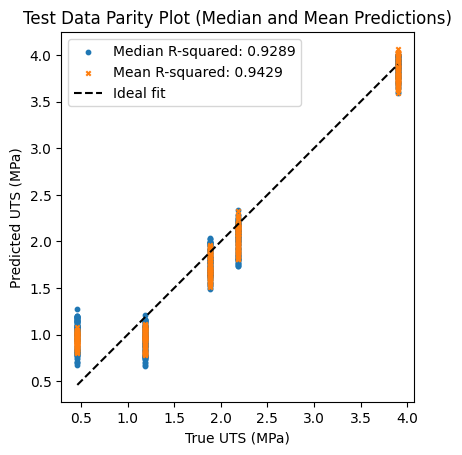

In [9]:
# Convert test_preds_history to a numpy array for easier manipulation
test_preds_history = np.array(test_preds_history)

# Calculate median and mean predictions across folds
median_preds_test = np.median(np.vstack(test_preds_history), axis=0)
mean_preds_test = np.mean(np.vstack(test_preds_history), axis=0)

# Calculate the median and mean MSE and R-squared
# median_test_mse = np.median((median_preds_test - true_labels_test)**2)
median_test_mse = np.mean((median_preds_test - true_labels_test)**2)
median_test_r2 = r2_score(true_labels_test, median_preds_test)
mean_test_mse = np.mean((mean_preds_test - true_labels_test)**2)
mean_test_r2 = r2_score(true_labels_test, mean_preds_test)

print(f"Median Test MSE: {median_test_mse:.4f}, Median Test R-squared: {median_test_r2:.4f}")
print(f"Mean Test MSE: {mean_test_mse:.4f}, Mean Test R-squared: {mean_test_r2:.4f}")

# Plotting the parity plot based on median predictions
fig, ax = plt.subplots()
ax.scatter(true_labels_test, median_preds_test, s=10, marker='o', label=f'Median R-squared: {median_test_r2:.4f}')
ax.scatter(true_labels_test, mean_preds_test, s=10, marker='x', label=f'Mean R-squared: {mean_test_r2:.4f}')
ax.plot([true_labels_test.min(), true_labels_test.max()], [true_labels_test.min(), true_labels_test.max()], color='black', linestyle='--', label='Ideal fit')
ax.set_xlabel('True UTS (MPa)')
ax.set_ylabel('Predicted UTS (MPa)')
ax.set_aspect('equal')
ax.set_title('Test Data Parity Plot (Median and Mean Predictions)')
ax.legend()
plt.show()

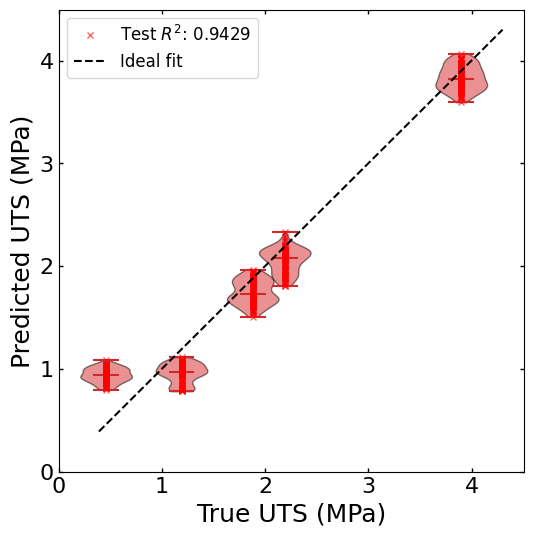

In [10]:
test_label_added = False
fig, ax = plt.subplots(figsize=(6, 6))
test_label_added = False
for i, label in enumerate(np.unique(true_labels_test)):
    mask = true_labels_test == label
    preds_for_label = mean_preds_test[mask]
    parts = ax.violinplot(preds_for_label, positions=[label], showmeans=False, showmedians=True)
    for pc in parts['bodies']:
        pc.set_facecolor('tab:red')
        pc.set_edgecolor('black')
        pc.set_alpha(0.5)

    # Set the color of the median line
    parts['cmedians'].set_color('tab:red')
    parts['cmins'].set_color('tab:red')  # Lower quartile line
    parts['cmaxes'].set_color('tab:red')  # Upper quartile line

    if not test_label_added:
        ax.plot([label] * len(preds_for_label), preds_for_label, 'rx', markersize=4, label=f'Test $R^2$: {mean_test_r2:.4f}', alpha=0.6)
        test_label_added = True  # Add the label only for the first plot
    else:
        ax.plot([label] * len(preds_for_label), preds_for_label, 'rx', markersize=4, alpha=0.6)

ax.plot([true_labels_train.min(), true_labels_test.max()+0.4], [true_labels_train.min(), true_labels_test.max()+0.4], label='Ideal fit',color='black', linestyle='--')


# ax.set_aspect('equal')
ax.set_xlabel('True UTS (MPa)', fontsize=18)
ax.set_ylabel('Predicted UTS (MPa)', fontsize=18)


ax.tick_params(axis="x",direction="in", top=True,length=3, width=1)
ax.tick_params(axis="y",direction="in", right=True,length=3, width=1)
ax.legend(loc='upper left',prop={'size': 12})
plt.xticks(np.arange(0, 4.2, 1),fontsize=16)
plt.yticks(np.arange(0, 4.2, 1),fontsize=16)
# ax.set_ylim([0.1, 4.8])
plt.show()

# Plot predictions for test data at z-stack

In [12]:
import re
depths = []

# Get the unique values in the array
unique_values, counts = np.unique(true_labels_test, return_counts=True)

# For each unique value, generate a sequence from 0 to the count of that value - 1
for value in unique_values:
    value_indices = np.where(true_labels_test == value)[0]  # Find indices where the value occurs
    depths.append(np.arange(len(value_indices)))  # Create a sequence from 0 to n-1

# Convert the result into a 2D array (each unique value gets a row)
depths_2d = np.array(depths)


<ipython-input-13-e247317a5931>:16: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  im = ax.scatter(depths[i]*7.5, mean_preds_test[i], c=bias[i], cmap='coolwarm',vmin=-0.5, vmax=0.5, s=80,edgecolor='k', marker=markers[i])


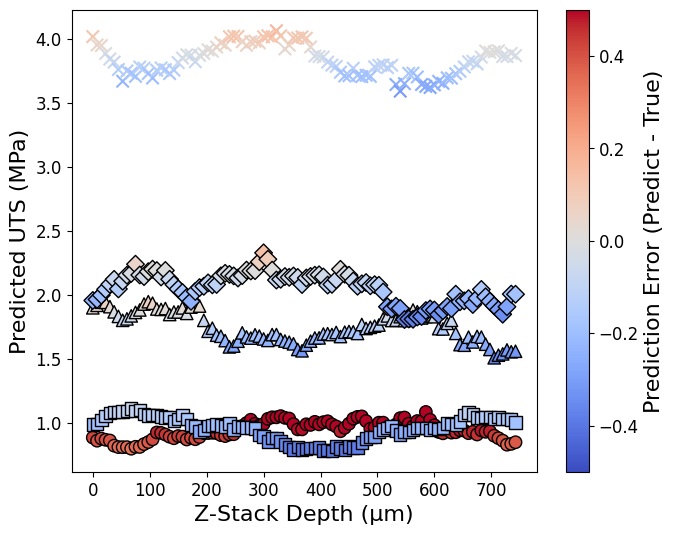

In [13]:
import matplotlib.pyplot as plt
import numpy as np


depths = np.array(depths).reshape(5,100)
mean_preds_test = np.array(mean_preds_test).reshape(5,100)
true_labels_test = np.array(true_labels_test).reshape(5,100)
bias = mean_preds_test - true_labels_test

# Define different markers for each sample
markers = ['o', 's', '^', 'D', 'x']  # Circle, Square, Triangle, Diamond, X

fig, ax = plt.subplots(figsize=(7.5, 6))
# Plot each sample with a different marker
for i in range(5):
    im = ax.scatter(depths[i]*7.5, mean_preds_test[i], c=bias[i], cmap='coolwarm',vmin=-0.5, vmax=0.5, s=80,edgecolor='k', marker=markers[i])

cb = plt.colorbar(im)
cb.set_label('Prediction Error (Predict - True)', fontsize=16)   # assign a label to the colorbar
ax.set_xlabel('Z-Stack Depth (µm)', fontsize=16)
ax.set_ylabel('Predicted UTS (MPa)', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cb.ax.tick_params(labelsize=12)

# Meta Leanrner

Without Meta learner:

Train MSE: 0.2564 ± 0.1335

Train R-squared: 0.8350 ± 0.1004

Validation MSE: 0.1631 ± 0.0476

Validation R-squared: 0.8846 ± 0.0420

Test MSE: 0.1827 ± 0.0722

Test R-squared: 0.8629 ± 0.0542



Simple Mean as Meta-Learner

Using device: cpu
Fold 1/5
Using Mean of Predictions:
Train MSE: 0.4578, R-squared: 0.7322
Validation MSE: 0.1703, R-squared: 0.8492
Test MSE: 0.1231, R-squared: 0.9076


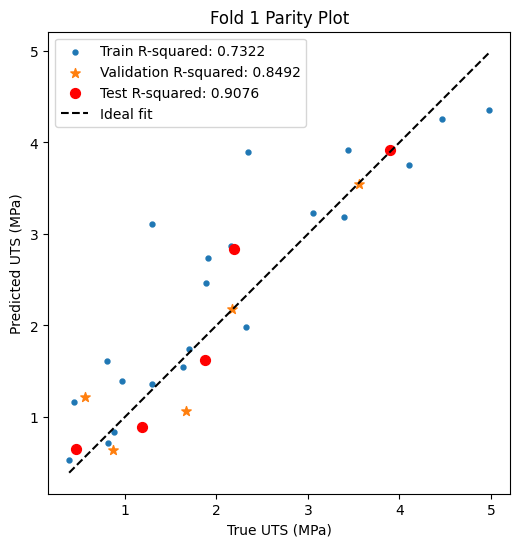

Fold 2/5
Using Mean of Predictions:
Train MSE: 0.0856, R-squared: 0.9424
Validation MSE: 0.3490, R-squared: 0.8349
Test MSE: 0.1473, R-squared: 0.8894


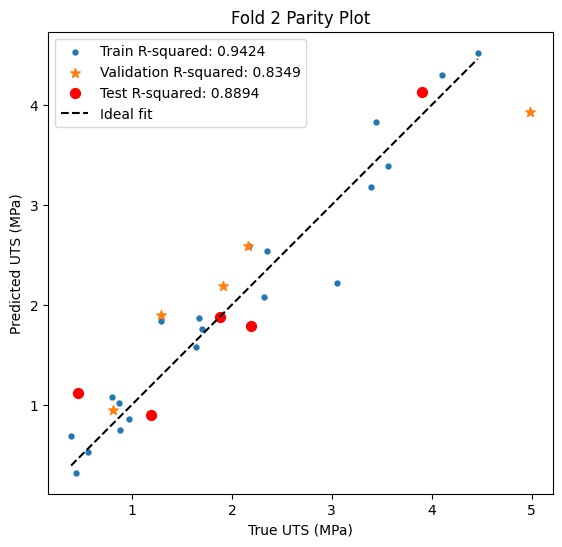

Fold 3/5
Using Mean of Predictions:
Train MSE: 0.1172, R-squared: 0.9228
Validation MSE: 0.2806, R-squared: 0.8608
Test MSE: 0.3016, R-squared: 0.7735


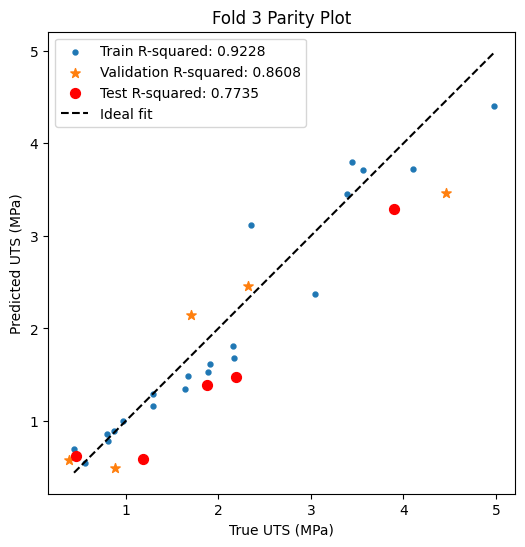

Fold 4/5
Using Mean of Predictions:
Train MSE: 0.0648, R-squared: 0.9608
Validation MSE: 0.2494, R-squared: 0.8261
Test MSE: 0.0743, R-squared: 0.9442


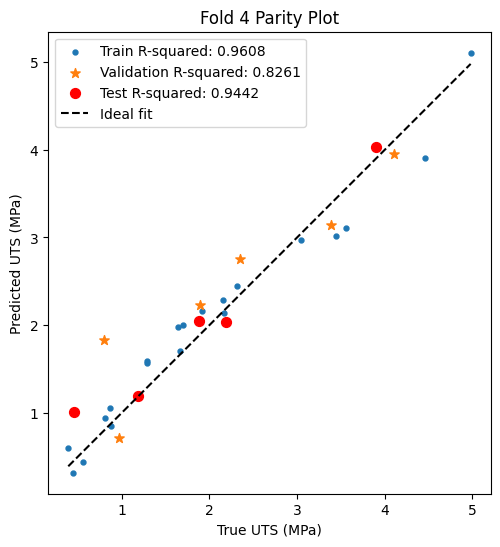

Fold 5/5
Using Mean of Predictions:
Train MSE: 0.2162, R-squared: 0.8730
Validation MSE: 0.4171, R-squared: 0.6658
Test MSE: 0.1443, R-squared: 0.8917


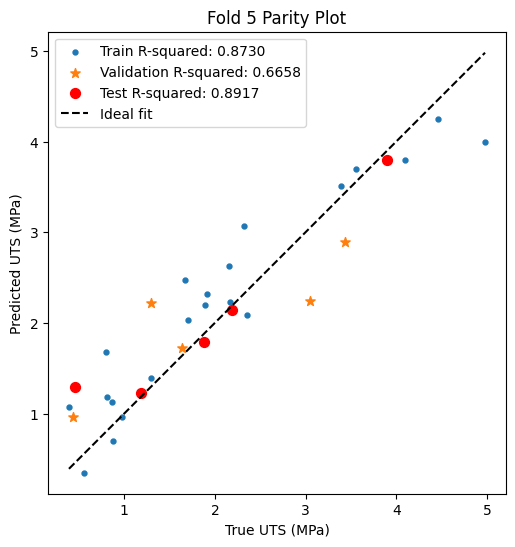

Test MSE: 0.0651, R-squared: 0.9511
Final Statistics Across All Folds:
Train MSE: 0.1883 ± 0.1444
Train R-squared: 0.8863 ± 0.0824
Validation MSE: 0.2933 ± 0.0844
Validation R-squared: 0.8074 ± 0.0718
Test MSE: 0.1581 ± 0.0764
Test R-squared: 0.8813 ± 0.0573


In [15]:
import torch
import numpy as np
import random
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedGroupKFold
import os
import tqdm
from torchvision import transforms

# Set seeds for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

# Check if CUDA (GPU) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Data transformation and normalization
val_xform_list = [transforms.CenterCrop(224)]
params = {}
params['use_contrast'] = False
if params['use_contrast']:
    val_xform_list.append(transforms.RandomAutocontrast(p=1.0))
val_xform_list.append(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
offline_transforms = transforms.Compose(val_xform_list)

# Initialize lists to store R-squared and MSE for each fold
train_rsquared_all_fold = []
val_rsquared_all_fold = []
test_rsquared_all_fold = []

train_mse_all_fold = []
val_mse_all_fold = []
test_mse_all_fold = []

test_preds_history = []

# Initialize KFold object
n_splits = 5
kf = StratifiedGroupKFold(n_splits=n_splits)

# Prepare directories for saving predictions
output_dir = '/content/drive/MyDrive/Colab Notebooks/resnet18-v5-finetune/Saved_Output'
os.makedirs(output_dir, exist_ok=True)

# Initialize the linear regression model
# meta_learner = LinearRegression()

# Iterate over the folds
uts_label = [it[1][0] for it in train_val_dataset]  # Record the UTS chunk
sample_id = [it[1][1] for it in train_val_dataset]  # Record the sample

for fold, (train_index, val_index) in enumerate(kf.split(train_val_dataset, y=uts_label, groups=sample_id)):
    print(f"Fold {fold + 1}/{n_splits}")
    set_seed(42)

    # Prepare file names for saving predictions
    output_train_file = os.path.join(output_dir, f'preds_train_fold{fold + 1}.npy')
    output_val_file = os.path.join(output_dir, f'preds_val_fold{fold + 1}.npy')
    output_test_file = os.path.join(output_dir, f'preds_test_fold{fold + 1}.npy')

    if os.path.exists(output_train_file) and os.path.exists(output_val_file) and os.path.exists(output_test_file):
        # print("Loading saved outputs for this fold.")
        preds_train = np.load(output_train_file)
        true_labels_train = np.load(output_train_file.replace('preds', 'true_labels'))
        preds_val = np.load(output_val_file)
        true_labels_val = np.load(output_val_file.replace('preds', 'true_labels'))
        preds_test = np.load(output_test_file)
        true_labels_test = np.load(output_test_file.replace('preds', 'true_labels'))

        test_preds_history.append(preds_test)

        # Load sample IDs for training, validation, and test sets
        train_samples_id = np.load(output_train_file.replace('preds', 'sample_ids'))
        val_samples_id = np.load(output_val_file.replace('preds', 'sample_ids'))
        test_samples_id = np.load(output_test_file.replace('preds', 'sample_ids'))

        # === Meta-Learner Training on Aggregated Data === #
        def aggregate_predictions(preds, sample_ids, true_labels):
            unique_samples = np.unique(sample_ids)
            X_agg = []
            y_agg = []

            for sample in unique_samples:
                sample_indices = np.where(sample_ids == sample)
                # Keep all 100 prediction values for this sample as the input (flatten them)
                aggregated_preds = preds[sample_indices].flatten()  # Flatten into a 1D array
                X_agg.append(aggregated_preds)
                # Get the unique true label for this sample
                y_agg.append(true_labels[sample_indices][0])

            return np.array(X_agg), np.array(y_agg)

        # Aggregate predictions for train, validation, and test sets
        X_train, y_train = aggregate_predictions(preds_train, train_samples_id, true_labels_train)
        X_val, y_val = aggregate_predictions(preds_val, val_samples_id, true_labels_val)
        X_test, y_test = aggregate_predictions(preds_test, test_samples_id, true_labels_test)

        # Calculate the mean predictions across the 100 predictions for each sample
        mean_train_preds = np.mean(X_train, axis=1)
        mean_val_preds = np.mean(X_val, axis=1)
        mean_test_preds = np.mean(X_test, axis=1)

        # Calculate metrics using the mean predictions
        mse_train_mean = mean_squared_error(y_train, mean_train_preds)
        r2_train_mean = r2_score(y_train, mean_train_preds)
        mse_val_mean = mean_squared_error(y_val, mean_val_preds)
        r2_val_mean = r2_score(y_val, mean_val_preds)
        mse_test_mean = mean_squared_error(y_test, mean_test_preds)
        r2_test_mean = r2_score(y_test, mean_test_preds)

        print(f"Using Mean of Predictions:")
        print(f"Train MSE: {mse_train_mean:.4f}, R-squared: {r2_train_mean:.4f}")
        print(f"Validation MSE: {mse_val_mean:.4f}, R-squared: {r2_val_mean:.4f}")
        print(f"Test MSE: {mse_test_mean:.4f}, R-squared: {r2_test_mean:.4f}")


        # Store the R-squared and MSE for each fold
        train_rsquared_all_fold.append(r2_train_mean)
        train_mse_all_fold.append(mse_train_mean)
        val_rsquared_all_fold.append(r2_val_mean)
        val_mse_all_fold.append(mse_val_mean)
        test_rsquared_all_fold.append(r2_test_mean)
        test_mse_all_fold.append(mse_test_mean)

        # Plotting the parity plot
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.scatter(y_train, mean_train_preds, s=50, marker='.', label=f'Train R-squared: {r2_train_mean:.4f}')
        ax.scatter(y_val, mean_val_preds, s=50, marker='*', label=f'Validation R-squared: {r2_val_mean:.4f}')
        ax.scatter(y_test, mean_test_preds, s=50, marker='o', color='red', label=f'Test R-squared: {r2_test_mean:.4f}')
        ax.plot([true_labels_train.min(), true_labels_train.max()], [true_labels_train.min(), true_labels_train.max()], color='black', linestyle='--', label='Ideal fit')
        ax.set_xlabel('True UTS (MPa)')
        ax.set_ylabel('Predicted UTS (MPa)')
        ax.set_aspect('equal')
        ax.set_title(f'Fold {fold+1} Parity Plot')
        ax.legend()
        plt.show()

    else:
        print("No Pre-Saved Data for this fold.")

# Convert test_preds_history to a numpy array for easier manipulation
test_preds_history = np.array(test_preds_history)

# Calculate median and mean predictions across folds
median_preds_test = np.median(np.vstack(test_preds_history), axis=0)
mean_preds_test = np.mean(np.vstack(test_preds_history), axis=0)

def aggregate_predictions(preds, sample_ids, true_labels):
            unique_samples = np.unique(sample_ids)
            X_agg = []
            y_agg = []

            for sample in unique_samples:
                sample_indices = np.where(sample_ids == sample)
                # Keep all 100 prediction values for this sample as the input (flatten them)
                aggregated_preds = preds[sample_indices].flatten()  # Flatten into a 1D array
                X_agg.append(aggregated_preds)
                # Get the unique true label for this sample
                y_agg.append(true_labels[sample_indices][0])

            return np.array(X_agg), np.array(y_agg)

X_test, y_test = aggregate_predictions(mean_preds_test, test_samples_id, true_labels_test)
mean_test_preds = np.mean(X_test, axis=1)

mse_test_mean = mean_squared_error(y_test, mean_test_preds)
r2_test_mean = r2_score(y_test, mean_test_preds)
print(f"Test MSE: {mse_test_mean:.4f}, R-squared: {r2_test_mean:.4f}")


# Final statistics across all folds
print("Final Statistics Across All Folds:")
print(f"Train MSE: {np.mean(train_mse_all_fold):.4f} ± {np.std(train_mse_all_fold):.4f}")
print(f"Train R-squared: {np.mean(train_rsquared_all_fold):.4f} ± {np.std(train_rsquared_all_fold):.4f}")
print(f"Validation MSE: {np.mean(val_mse_all_fold):.4f} ± {np.std(val_mse_all_fold):.4f}")
print(f"Validation R-squared: {np.mean(val_rsquared_all_fold):.4f} ± {np.std(val_rsquared_all_fold):.4f}")
print(f"Test MSE: {np.mean(test_mse_all_fold):.4f} ± {np.std(test_mse_all_fold):.4f}")
print(f"Test R-squared: {np.mean(test_rsquared_all_fold):.4f} ± {np.std(test_rsquared_all_fold):.4f}")

meta_learner_results['Mean'] = {'MSE':{'Train':[np.mean(train_mse_all_fold), np.std(train_mse_all_fold)],
                                  'Validation': [np.mean(val_mse_all_fold), np.std(val_mse_all_fold)],
                                  'Test':[np.mean(test_mse_all_fold),np.std(test_mse_all_fold)]},
                           'R2':{'Train':[np.mean(train_rsquared_all_fold), np.std(train_rsquared_all_fold)],
                                  'Validation': [np.mean(val_rsquared_all_fold), np.std(val_rsquared_all_fold)],
                                  'Test':[np.mean(test_rsquared_all_fold),np.std(test_rsquared_all_fold)]}}


Ensemble + Mean meta learner

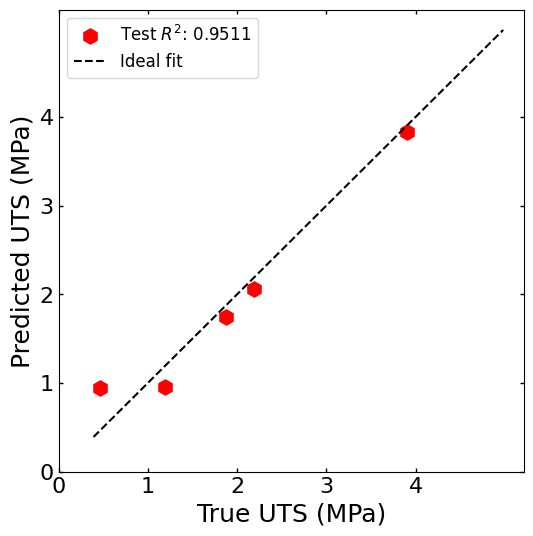

In [16]:
# Plotting the parity plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(y_test, mean_test_preds, s=120, marker='h', color='red', label=f'Test $R^2$: {r2_test_mean:.4f}')
ax.plot([true_labels_train.min(), true_labels_train.max()], [true_labels_train.min(), true_labels_train.max()], color='black', linestyle='--', label='Ideal fit')

ax.set_xlabel('True UTS (MPa)', fontsize=18)
ax.set_ylabel('Predicted UTS (MPa)', fontsize=18)
ax.tick_params(axis="x",direction="in", top=True,length=3, width=1)
ax.tick_params(axis="y",direction="in", right=True,length=3, width=1)
ax.legend(loc='upper left',prop={'size': 12})
plt.xticks(np.arange(0, 4.2, 1),fontsize=16)
plt.yticks(np.arange(0, 4.2, 1),fontsize=16)
plt.show()
fig.savefig('fig 8.jpg', dpi=600, bbox_inches='tight', transparent=True)

Simple Medain as Meta Learner

Using device: cpu
Fold 1/5
Using Mean of Predictions:
Train MSE: 0.4495, R-squared: 0.7371
Validation MSE: 0.1713, R-squared: 0.8483
Test MSE: 0.1453, R-squared: 0.8909


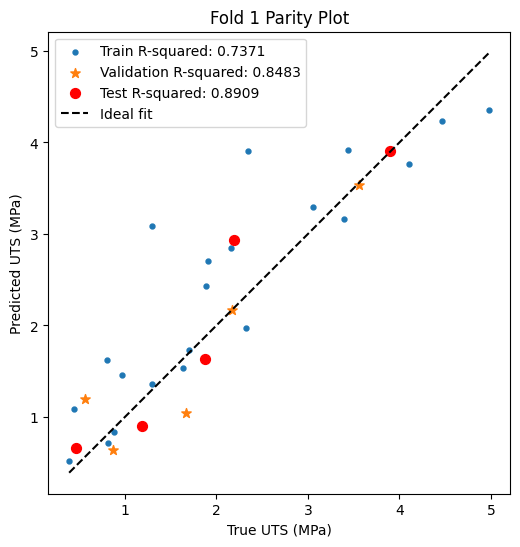

Fold 2/5
Using Mean of Predictions:
Train MSE: 0.0777, R-squared: 0.9478
Validation MSE: 0.3209, R-squared: 0.8482
Test MSE: 0.1587, R-squared: 0.8809


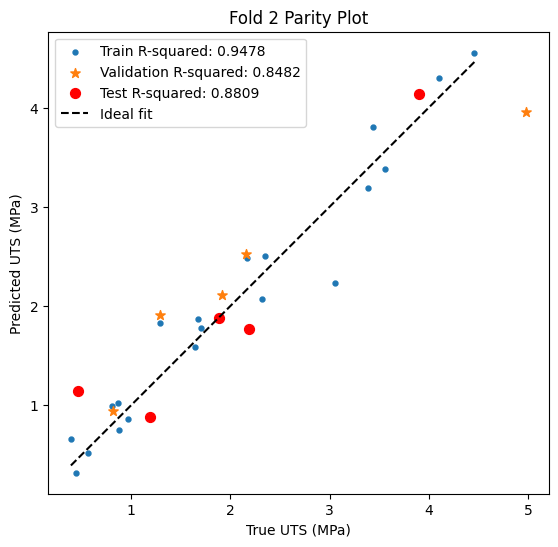

Fold 3/5
Using Mean of Predictions:
Train MSE: 0.1141, R-squared: 0.9249
Validation MSE: 0.2480, R-squared: 0.8769
Test MSE: 0.3035, R-squared: 0.7721


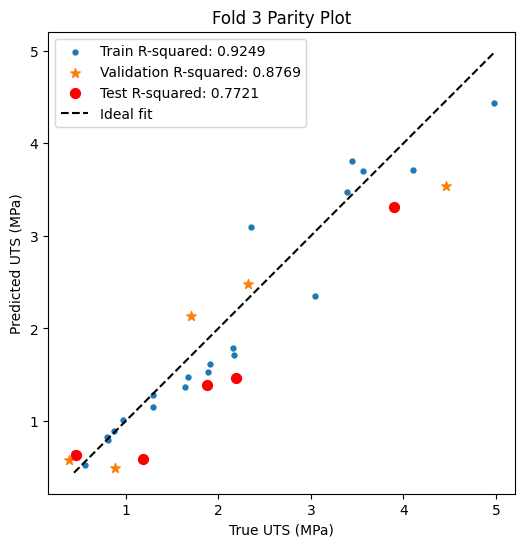

Fold 4/5
Using Mean of Predictions:
Train MSE: 0.0623, R-squared: 0.9623
Validation MSE: 0.2379, R-squared: 0.8341
Test MSE: 0.0780, R-squared: 0.9414


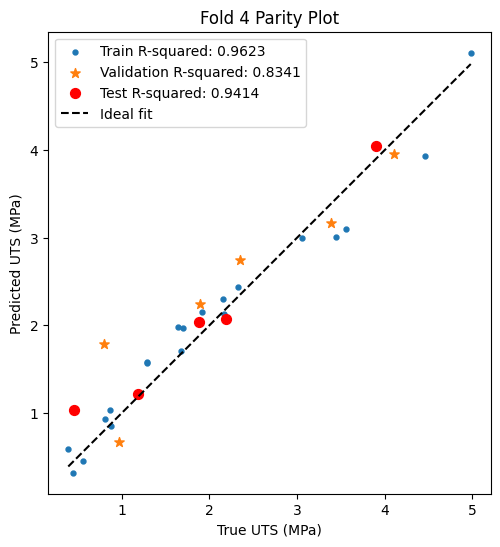

Fold 5/5
Using Mean of Predictions:
Train MSE: 0.2093, R-squared: 0.8771
Validation MSE: 0.4210, R-squared: 0.6627
Test MSE: 0.1467, R-squared: 0.8898


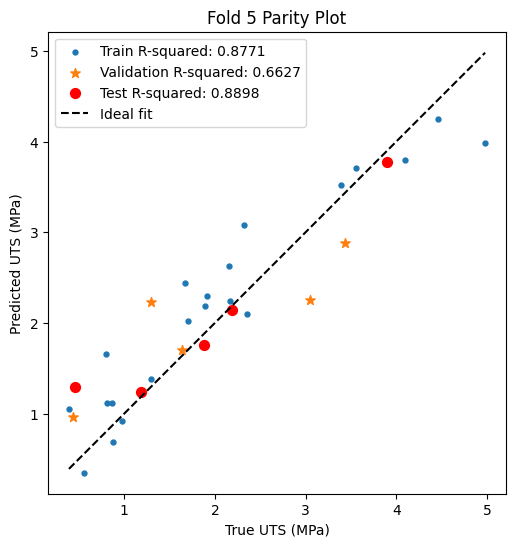

Final Statistics Across All Folds:
Train MSE: 0.1826 ± 0.1429
Train R-squared: 0.8898 ± 0.0816
Validation MSE: 0.2798 ± 0.0851
Validation R-squared: 0.8140 ± 0.0770
Test MSE: 0.1664 ± 0.0742
Test R-squared: 0.8750 ± 0.0557


In [19]:
import torch
import numpy as np
import random
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedGroupKFold
import os
import tqdm
from torchvision import transforms

# Set seeds for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

# Check if CUDA (GPU) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Data transformation and normalization
val_xform_list = [transforms.CenterCrop(224)]
params = {}
params['use_contrast'] = False
if params['use_contrast']:
    val_xform_list.append(transforms.RandomAutocontrast(p=1.0))
val_xform_list.append(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
offline_transforms = transforms.Compose(val_xform_list)

# Initialize lists to store R-squared and MSE for each fold
train_rsquared_all_fold = []
val_rsquared_all_fold = []
test_rsquared_all_fold = []

train_mse_all_fold = []
val_mse_all_fold = []
test_mse_all_fold = []

# Initialize KFold object
n_splits = 5
kf = StratifiedGroupKFold(n_splits=n_splits)

# Prepare directories for saving predictions
output_dir = '/content/drive/MyDrive/Colab Notebooks/resnet18-v5-finetune/Saved_Output'
os.makedirs(output_dir, exist_ok=True)

# Initialize the linear regression model
# meta_learner = LinearRegression()

# Iterate over the folds
uts_label = [it[1][0] for it in train_val_dataset]  # Record the UTS chunk
sample_id = [it[1][1] for it in train_val_dataset]  # Record the sample

for fold, (train_index, val_index) in enumerate(kf.split(train_val_dataset, y=uts_label, groups=sample_id)):
    print(f"Fold {fold + 1}/{n_splits}")
    set_seed(42)

    # Prepare file names for saving predictions
    output_train_file = os.path.join(output_dir, f'preds_train_fold{fold + 1}.npy')
    output_val_file = os.path.join(output_dir, f'preds_val_fold{fold + 1}.npy')
    output_test_file = os.path.join(output_dir, f'preds_test_fold{fold + 1}.npy')

    if os.path.exists(output_train_file) and os.path.exists(output_val_file) and os.path.exists(output_test_file):
        # print("Loading saved outputs for this fold.")
        preds_train = np.load(output_train_file)
        true_labels_train = np.load(output_train_file.replace('preds', 'true_labels'))
        preds_val = np.load(output_val_file)
        true_labels_val = np.load(output_val_file.replace('preds', 'true_labels'))
        preds_test = np.load(output_test_file)
        true_labels_test = np.load(output_test_file.replace('preds', 'true_labels'))

        # Load sample IDs for training, validation, and test sets
        train_samples_id = np.load(output_train_file.replace('preds', 'sample_ids'))
        val_samples_id = np.load(output_val_file.replace('preds', 'sample_ids'))
        test_samples_id = np.load(output_test_file.replace('preds', 'sample_ids'))

        # === Meta-Learner Training on Aggregated Data === #
        def aggregate_predictions(preds, sample_ids, true_labels):
            unique_samples = np.unique(sample_ids)
            X_agg = []
            y_agg = []

            for sample in unique_samples:
                sample_indices = np.where(sample_ids == sample)
                # Keep all 100 prediction values for this sample as the input (flatten them)
                aggregated_preds = preds[sample_indices].flatten()  # Flatten into a 1D array
                X_agg.append(aggregated_preds)
                # Get the unique true label for this sample
                y_agg.append(true_labels[sample_indices][0])

            return np.array(X_agg), np.array(y_agg)

        # Aggregate predictions for train, validation, and test sets
        X_train, y_train = aggregate_predictions(preds_train, train_samples_id, true_labels_train)
        X_val, y_val = aggregate_predictions(preds_val, val_samples_id, true_labels_val)
        X_test, y_test = aggregate_predictions(preds_test, test_samples_id, true_labels_test)

        # Calculate the mean predictions across the 100 predictions for each sample
        median_train_preds = np.median(X_train, axis=1)
        median_val_preds = np.median(X_val, axis=1)
        median_test_preds = np.median(X_test, axis=1)

        # Calculate metrics using the mean predictions
        mse_train_median = mean_squared_error(y_train, median_train_preds)
        r2_train_median = r2_score(y_train, median_train_preds)
        mse_val_median = mean_squared_error(y_val, median_val_preds)
        r2_val_median = r2_score(y_val, median_val_preds)
        mse_test_median = mean_squared_error(y_test, median_test_preds)
        r2_test_median = r2_score(y_test, median_test_preds)

        print(f"Using Mean of Predictions:")
        print(f"Train MSE: {mse_train_median:.4f}, R-squared: {r2_train_median:.4f}")
        print(f"Validation MSE: {mse_val_median:.4f}, R-squared: {r2_val_median:.4f}")
        print(f"Test MSE: {mse_test_median:.4f}, R-squared: {r2_test_median:.4f}")


        # Store the R-squared and MSE for each fold
        train_rsquared_all_fold.append(r2_train_median)
        train_mse_all_fold.append(mse_train_median)
        val_rsquared_all_fold.append(r2_val_median)
        val_mse_all_fold.append(mse_val_median)
        test_rsquared_all_fold.append(r2_test_median)
        test_mse_all_fold.append(mse_test_median)

        # Plotting the parity plot
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.scatter(y_train, median_train_preds, s=50, marker='.', label=f'Train R-squared: {r2_train_median:.4f}')
        ax.scatter(y_val, median_val_preds, s=50, marker='*', label=f'Validation R-squared: {r2_val_median:.4f}')
        ax.scatter(y_test, median_test_preds, s=50, marker='o', color='red', label=f'Test R-squared: {r2_test_median:.4f}')
        ax.plot([true_labels_train.min(), true_labels_train.max()], [true_labels_train.min(), true_labels_train.max()], color='black', linestyle='--', label='Ideal fit')
        ax.set_xlabel('True UTS (MPa)')
        ax.set_ylabel('Predicted UTS (MPa)')
        ax.set_aspect('equal')
        ax.set_title(f'Fold {fold+1} Parity Plot')
        ax.legend()
        plt.show()

    else:
        print("No Pre-Saved Data for this fold.")

# Final statistics across all folds
print("Final Statistics Across All Folds:")
print(f"Train MSE: {np.mean(train_mse_all_fold):.4f} ± {np.std(train_mse_all_fold):.4f}")
print(f"Train R-squared: {np.mean(train_rsquared_all_fold):.4f} ± {np.std(train_rsquared_all_fold):.4f}")
print(f"Validation MSE: {np.mean(val_mse_all_fold):.4f} ± {np.std(val_mse_all_fold):.4f}")
print(f"Validation R-squared: {np.mean(val_rsquared_all_fold):.4f} ± {np.std(val_rsquared_all_fold):.4f}")
print(f"Test MSE: {np.mean(test_mse_all_fold):.4f} ± {np.std(test_mse_all_fold):.4f}")
print(f"Test R-squared: {np.mean(test_rsquared_all_fold):.4f} ± {np.std(test_rsquared_all_fold):.4f}")

meta_learner_results['Median'] = {'MSE':{'Train':[np.mean(train_mse_all_fold), np.std(train_mse_all_fold)],
                                  'Validation': [np.mean(val_mse_all_fold), np.std(val_mse_all_fold)],
                                  'Test':[np.mean(test_mse_all_fold),np.std(test_mse_all_fold)]},
                           'R2':{'Train':[np.mean(train_rsquared_all_fold), np.std(train_rsquared_all_fold)],
                                  'Validation': [np.mean(val_rsquared_all_fold), np.std(val_rsquared_all_fold)],
                                  'Test':[np.mean(test_rsquared_all_fold),np.std(test_rsquared_all_fold)]}}


Ensemble + Median meta learner for test data

Test MSE: 0.0636, R-squared: 0.9523


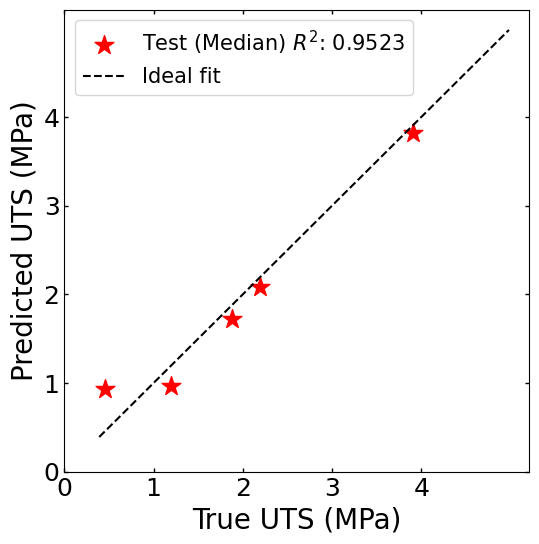

In [57]:
mean_preds_test = np.mean(np.vstack(test_preds_history), axis=0)
X_test, y_test = aggregate_predictions(mean_preds_test, test_samples_id, true_labels_test)
median_test_preds = np.median(X_test, axis=1)

mse_test_median = mean_squared_error(y_test, median_test_preds)
r2_test_median = r2_score(y_test, median_test_preds)
print(f"Test MSE: {mse_test_median:.4f}, R-squared: {r2_test_median:.4f}")
# Plotting the parity plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(y_test, median_test_preds, s=200, marker='*', color='r', label=f'Test (Median) $R^2$: {r2_test_median:.4f}')
ax.plot([true_labels_train.min(), true_labels_train.max()], [true_labels_train.min(), true_labels_train.max()], color='black', linestyle='--', label='Ideal fit')

ax.set_xlabel('True UTS (MPa)', fontsize=20)
ax.set_ylabel('Predicted UTS (MPa)', fontsize=20)
ax.tick_params(axis="x",direction="in", top=True,length=3, width=1)
ax.tick_params(axis="y",direction="in", right=True,length=3, width=1)
ax.legend(loc='upper left',prop={'size': 15})
plt.xticks(np.arange(0, 4.2, 1),fontsize=18)
plt.yticks(np.arange(0, 4.2, 1),fontsize=18)
plt.show()
fig.savefig('fig 9.jpg', dpi=1000, bbox_inches='tight', transparent=True)

Linear Regressor as Meta Learner

Using device: cpu
Fold 1/5
Train MSE: 3.538333688546391e-12, R-squared: 1.0
Validation MSE: 1.0527654886245728, R-squared: 0.06803905963897705
Test MSE: 0.5718985795974731, R-squared: 0.5706028938293457


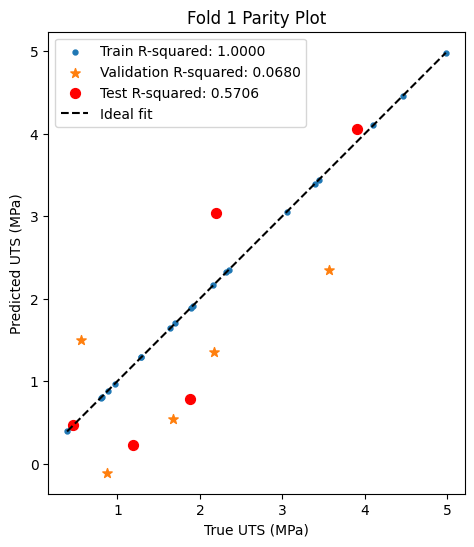

Fold 2/5
Train MSE: 3.448247004773919e-13, R-squared: 1.0
Validation MSE: 0.4794003963470459, R-squared: 0.7732216119766235
Test MSE: 0.21995118260383606, R-squared: 0.8348546028137207


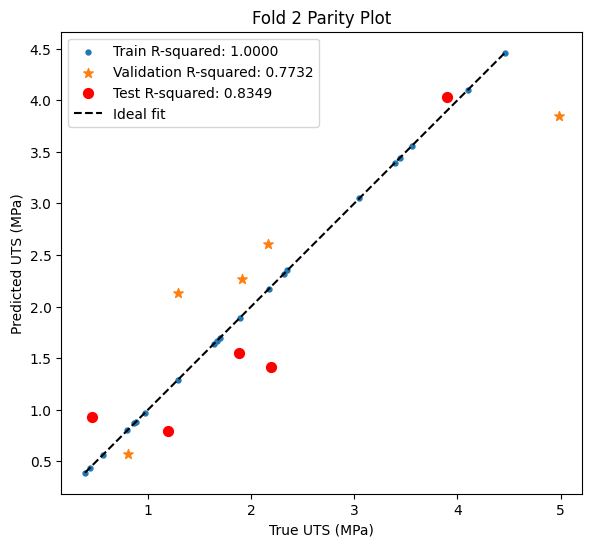

Fold 3/5
Train MSE: 2.7935325493805285e-13, R-squared: 1.0
Validation MSE: 0.1192798763513565, R-squared: 0.940821647644043
Test MSE: 0.6666867136955261, R-squared: 0.49943333864212036


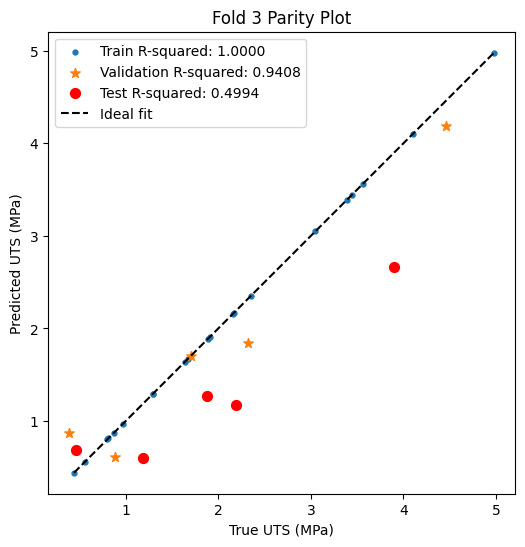

Fold 4/5
Train MSE: 3.9133141714088604e-13, R-squared: 1.0
Validation MSE: 0.3019391596317291, R-squared: 0.7894084453582764
Test MSE: 0.26237601041793823, R-squared: 0.8030009269714355


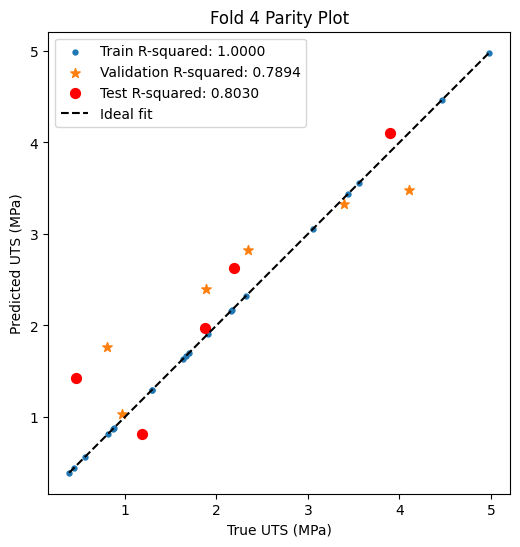

Fold 5/5
Train MSE: 7.014071940446287e-13, R-squared: 1.0
Validation MSE: 0.3353408873081207, R-squared: 0.7313323020935059
Test MSE: 0.3424188494682312, R-squared: 0.7429025173187256


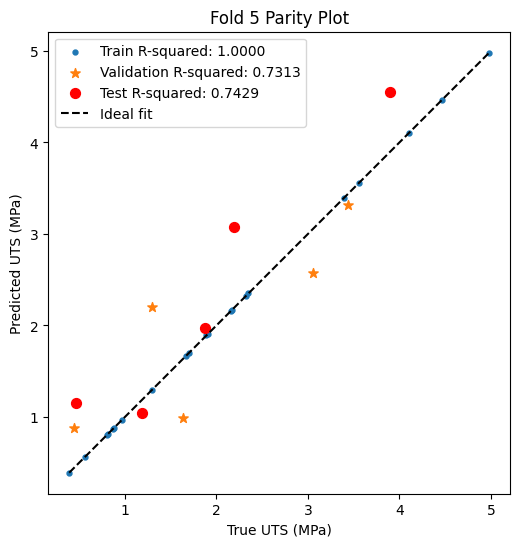

Final Statistics Across All Folds:
Train MSE: 0.0000 ± 0.0000
Train R-squared: 1.0000 ± 0.0000
Validation MSE: 0.4577 ± 0.3189
Validation R-squared: 0.6606 ± 0.3046
Test MSE: 0.4127 ± 0.1758
Test R-squared: 0.6902 ± 0.1320


In [26]:
import torch
import numpy as np
import random
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedGroupKFold
import os
import tqdm
from torchvision import transforms

# Set seeds for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

# Check if CUDA (GPU) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Data transformation and normalization
val_xform_list = [transforms.CenterCrop(224)]
params = {}
params['use_contrast'] = False
if params['use_contrast']:
    val_xform_list.append(transforms.RandomAutocontrast(p=1.0))
val_xform_list.append(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
offline_transforms = transforms.Compose(val_xform_list)

# Initialize lists to store R-squared and MSE for each fold
train_rsquared_all_fold = []
val_rsquared_all_fold = []
test_rsquared_all_fold = []

train_mse_all_fold = []
val_mse_all_fold = []
test_mse_all_fold = []

# Initialize KFold object
n_splits = 5
kf = StratifiedGroupKFold(n_splits=n_splits)

# Prepare directories for saving predictions
output_dir = '/content/drive/MyDrive/Colab Notebooks/resnet18-v5-finetune/Saved_Output'
os.makedirs(output_dir, exist_ok=True)

# Initialize the linear regression model
meta_learner = LinearRegression()

# Iterate over the folds
uts_label = [it[1][0] for it in train_val_dataset]  # Record the UTS chunk
sample_id = [it[1][1] for it in train_val_dataset]  # Record the sample

for fold, (train_index, val_index) in enumerate(kf.split(train_val_dataset, y=uts_label, groups=sample_id)):
    print(f"Fold {fold + 1}/{n_splits}")
    set_seed(42)

    # Prepare file names for saving predictions
    output_train_file = os.path.join(output_dir, f'preds_train_fold{fold + 1}.npy')
    output_val_file = os.path.join(output_dir, f'preds_val_fold{fold + 1}.npy')
    output_test_file = os.path.join(output_dir, f'preds_test_fold{fold + 1}.npy')

    if os.path.exists(output_train_file) and os.path.exists(output_val_file) and os.path.exists(output_test_file):
        # print("Loading saved outputs for this fold.")
        preds_train = np.load(output_train_file)
        true_labels_train = np.load(output_train_file.replace('preds', 'true_labels'))
        preds_val = np.load(output_val_file)
        true_labels_val = np.load(output_val_file.replace('preds', 'true_labels'))
        preds_test = np.load(output_test_file)
        true_labels_test = np.load(output_test_file.replace('preds', 'true_labels'))

        # Load sample IDs for training, validation, and test sets
        train_samples_id = np.load(output_train_file.replace('preds', 'sample_ids'))
        val_samples_id = np.load(output_val_file.replace('preds', 'sample_ids'))
        test_samples_id = np.load(output_test_file.replace('preds', 'sample_ids'))

        # === Meta-Learner Training on Aggregated Data === #
        def aggregate_predictions(preds, sample_ids, true_labels):
            unique_samples = np.unique(sample_ids)
            X_agg = []
            y_agg = []

            for sample in unique_samples:
                sample_indices = np.where(sample_ids == sample)
                # Keep all 100 prediction values for this sample as the input (flatten them)
                aggregated_preds = preds[sample_indices].flatten()  # Flatten into a 1D array
                X_agg.append(aggregated_preds)
                # Get the unique true label for this sample
                y_agg.append(true_labels[sample_indices][0])

            return np.array(X_agg), np.array(y_agg)

        # Aggregate predictions for train, validation, and test sets
        X_train, y_train = aggregate_predictions(preds_train, train_samples_id, true_labels_train)
        X_val, y_val = aggregate_predictions(preds_val, val_samples_id, true_labels_val)
        X_test, y_test = aggregate_predictions(preds_test, test_samples_id, true_labels_test)

        # # Standardize the features for better performance
        # scaler = StandardScaler()
        # X_train_scaled = scaler.fit_transform(X_train)
        # X_val_scaled = scaler.transform(X_val)
        # X_test_scaled = scaler.transform(X_test)

        # Train the meta-learner on the aggregated train data
        meta_learner.fit(X_train, y_train)

        # Predict with the meta-learner on the validation and test sets
        train_preds = meta_learner.predict(X_train)
        val_preds = meta_learner.predict(X_val)
        test_preds = meta_learner.predict(X_test)

        # Calculate metrics on validation and test data
        r_squared_train = r2_score(y_train, train_preds)
        mse_train = mean_squared_error(y_train, train_preds)
        r_squared_val = r2_score(y_val, val_preds)
        mse_val = mean_squared_error(y_val, val_preds)
        r_squared_test = r2_score(y_test, test_preds)
        mse_test = mean_squared_error(y_test, test_preds)
        print(f'Train MSE: {mse_train}, R-squared: {r_squared_train}')
        print(f'Validation MSE: {mse_val}, R-squared: {r_squared_val}')
        print(f'Test MSE: {mse_test}, R-squared: {r_squared_test}')

        # Store the R-squared and MSE for each fold
        train_rsquared_all_fold.append(r_squared_train)
        train_mse_all_fold.append(mse_train)
        val_rsquared_all_fold.append(r_squared_val)
        val_mse_all_fold.append(mse_val)
        test_rsquared_all_fold.append(r_squared_test)
        test_mse_all_fold.append(mse_test)

        # Plotting the parity plot
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.scatter(y_train, train_preds, s=50, marker='.', label=f'Train R-squared: {r_squared_train:.4f}')
        ax.scatter(y_val, val_preds, s=50, marker='*', label=f'Validation R-squared: {r_squared_val:.4f}')
        ax.scatter(y_test, test_preds, s=50, marker='o', color='red', label=f'Test R-squared: {r_squared_test:.4f}')
        ax.plot([true_labels_train.min(), true_labels_train.max()], [true_labels_train.min(), true_labels_train.max()], color='black', linestyle='--', label='Ideal fit')
        ax.set_xlabel('True UTS (MPa)')
        ax.set_ylabel('Predicted UTS (MPa)')
        ax.set_aspect('equal')
        ax.set_title(f'Fold {fold+1} Parity Plot')
        ax.legend()
        plt.show()

    else:
        print("No Pre-Saved Data for this fold.")

# Final statistics across all folds
print("Final Statistics Across All Folds:")
print(f"Train MSE: {np.mean(train_mse_all_fold):.4f} ± {np.std(train_mse_all_fold):.4f}")
print(f"Train R-squared: {np.mean(train_rsquared_all_fold):.4f} ± {np.std(train_rsquared_all_fold):.4f}")
print(f"Validation MSE: {np.mean(val_mse_all_fold):.4f} ± {np.std(val_mse_all_fold):.4f}")
print(f"Validation R-squared: {np.mean(val_rsquared_all_fold):.4f} ± {np.std(val_rsquared_all_fold):.4f}")
print(f"Test MSE: {np.mean(test_mse_all_fold):.4f} ± {np.std(test_mse_all_fold):.4f}")
print(f"Test R-squared: {np.mean(test_rsquared_all_fold):.4f} ± {np.std(test_rsquared_all_fold):.4f}")

meta_learner_results['Linear'] = {'MSE':{'Train':[np.mean(train_mse_all_fold), np.std(train_mse_all_fold)],
                                  'Validation': [np.mean(val_mse_all_fold), np.std(val_mse_all_fold)],
                                  'Test':[np.mean(test_mse_all_fold),np.std(test_mse_all_fold)]},
                           'R2':{'Train':[np.mean(train_rsquared_all_fold), np.std(train_rsquared_all_fold)],
                                  'Validation': [np.mean(val_rsquared_all_fold), np.std(val_rsquared_all_fold)],
                                  'Test':[np.mean(test_rsquared_all_fold),np.std(test_rsquared_all_fold)]}}


Ensemble + Linear Meat Leanrer

Test MSE: 0.2679, R-squared: 0.7988


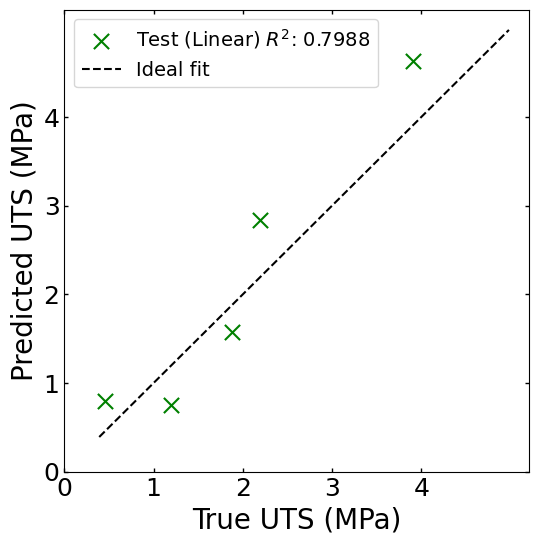

In [27]:
mean_preds_test = np.mean(np.vstack(test_preds_history), axis=0)
X_test, y_test = aggregate_predictions(mean_preds_test, test_samples_id, true_labels_test)
linear_test_preds = meta_learner.predict(X_test)

mse_test_median = mean_squared_error(y_test, linear_test_preds)
r2_test_median = r2_score(y_test, linear_test_preds)
print(f"Test MSE: {mse_test_median:.4f}, R-squared: {r2_test_median:.4f}")
# Plotting the parity plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(y_test, linear_test_preds, s=120, marker='x', color='green', label=f'Test (Linear) $R^2$: {r2_test_median:.4f}')
ax.plot([true_labels_train.min(), true_labels_train.max()], [true_labels_train.min(), true_labels_train.max()], color='black', linestyle='--', label='Ideal fit')

ax.set_xlabel('True UTS (MPa)', fontsize=20)
ax.set_ylabel('Predicted UTS (MPa)', fontsize=20)
ax.tick_params(axis="x",direction="in", top=True,length=3, width=1)
ax.tick_params(axis="y",direction="in", right=True,length=3, width=1)
ax.legend(loc='upper left',prop={'size': 14})
plt.xticks(np.arange(0, 4.2, 1),fontsize=18)
plt.yticks(np.arange(0, 4.2, 1),fontsize=18)
plt.show()
fig.savefig('fig 9.jpg', dpi=1000, bbox_inches='tight', transparent=True)

SVR as Meta Learner

Using device: cpu
Fold 1/5
Train MSE: 0.3680830205225406, R-squared: 0.784713531262051
Validation MSE: 0.2371950682191784, R-squared: 0.7900229859611538
Test MSE: 0.10926509708038493, R-squared: 0.9179607736456689


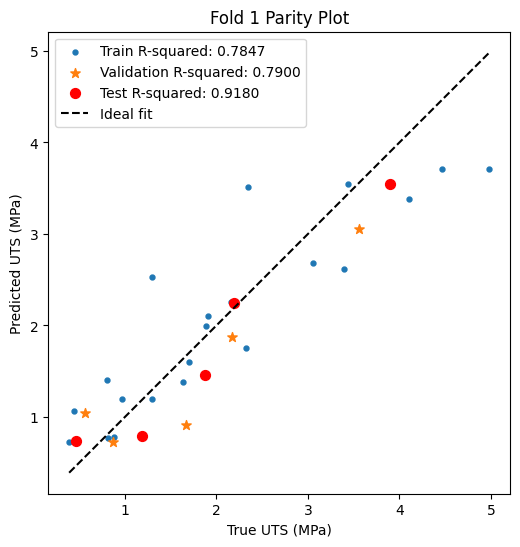

Fold 2/5
Train MSE: 0.08050008632100195, R-squared: 0.9458773757348868
Validation MSE: 0.3694451331582589, R-squared: 0.8252355168050199
Test MSE: 0.14905511470527352, R-squared: 0.8880853390394146


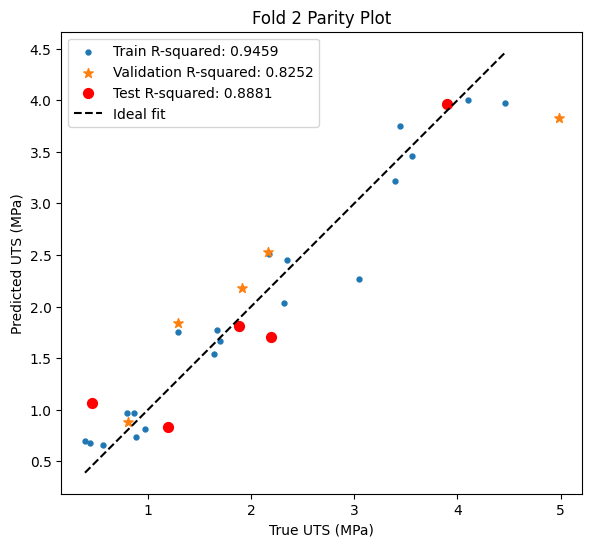

Fold 3/5
Train MSE: 0.12411393005694758, R-squared: 0.9182779821288093
Validation MSE: 0.5212672606996807, R-squared: 0.741383582185553
Test MSE: 0.24321205660974443, R-squared: 0.8173897292231378


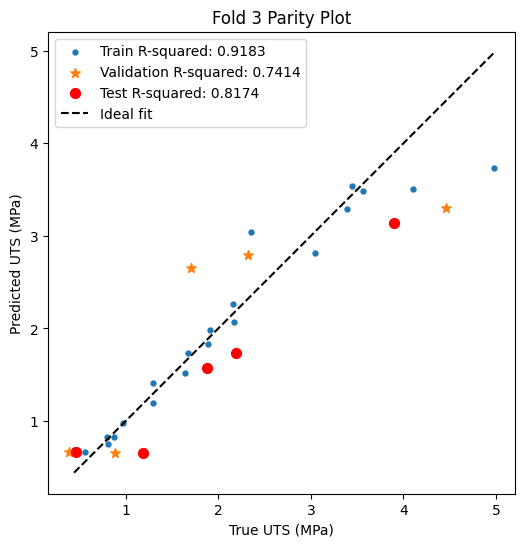

Fold 4/5
Train MSE: 0.07414681743234082, R-squared: 0.9551753532886477
Validation MSE: 0.2040061038663122, R-squared: 0.8577131732311747
Test MSE: 0.0776228680937492, R-squared: 0.9417186254716771


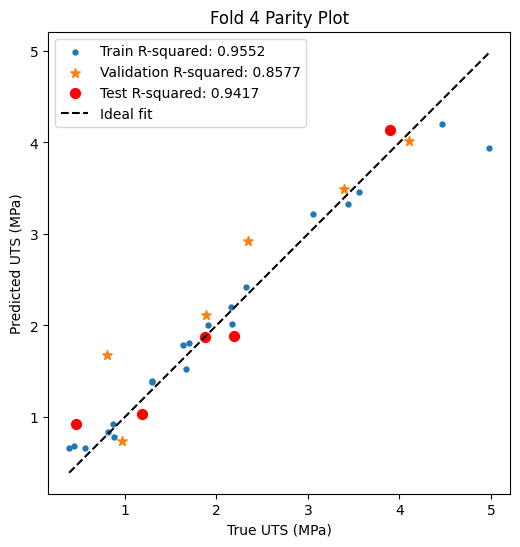

Fold 5/5
Train MSE: 0.10171556375695087, R-squared: 0.9402547695922265
Validation MSE: 0.6099003668942481, R-squared: 0.5113613151181708
Test MSE: 0.10593937958060158, R-squared: 0.9204578133961993


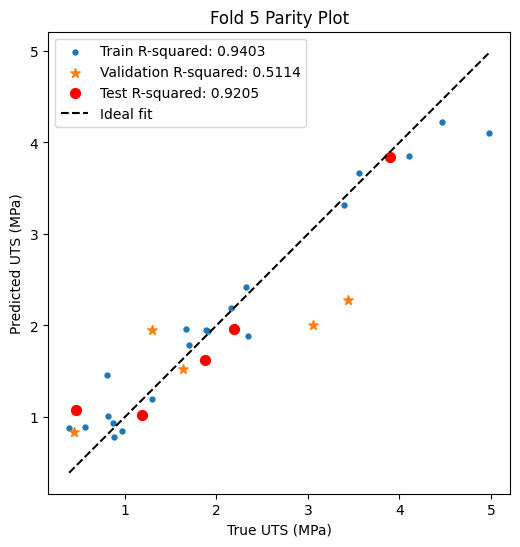

Final Statistics Across All Folds:
Train MSE: 0.1497 ± 0.1106
Train R-squared: 0.9089 ± 0.0632
Validation MSE: 0.3884 ± 0.1574
Validation R-squared: 0.7451 ± 0.1231
Test MSE: 0.1370 ± 0.0578
Test R-squared: 0.8971 ± 0.0434


In [28]:
import torch
import numpy as np
import random
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.svm import SVR  # Change to SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedGroupKFold
import os
import tqdm
from torchvision import transforms

# Set seeds for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

# Check if CUDA (GPU) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Data transformation and normalization
val_xform_list = [transforms.CenterCrop(224)]
params = {}
params['use_contrast'] = False
if params['use_contrast']:
    val_xform_list.append(transforms.RandomAutocontrast(p=1.0))
val_xform_list.append(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
offline_transforms = transforms.Compose(val_xform_list)

# Initialize lists to store R-squared and MSE for each fold
train_rsquared_all_fold = []
val_rsquared_all_fold = []
test_rsquared_all_fold = []

train_mse_all_fold = []
val_mse_all_fold = []
test_mse_all_fold = []

# Initialize KFold object
n_splits = 5
kf = StratifiedGroupKFold(n_splits=n_splits)

# Prepare directories for saving predictions
output_dir = '/content/drive/MyDrive/Colab Notebooks/resnet18-v5-finetune/Saved_Output'
os.makedirs(output_dir, exist_ok=True)

# Initialize the SVR meta-learner
meta_learner = SVR(kernel='rbf', C=1.0, epsilon=0.1)  # Changed from LinearRegression to SVR

# Iterate over the folds
uts_label = [it[1][0] for it in train_val_dataset]  # Record the UTS chunk
sample_id = [it[1][1] for it in train_val_dataset]  # Record the sample

for fold, (train_index, val_index) in enumerate(kf.split(train_val_dataset, y=uts_label, groups=sample_id)):
    print(f"Fold {fold + 1}/{n_splits}")
    set_seed(42)

    # Prepare file names for saving predictions
    output_train_file = os.path.join(output_dir, f'preds_train_fold{fold + 1}.npy')
    output_val_file = os.path.join(output_dir, f'preds_val_fold{fold + 1}.npy')
    output_test_file = os.path.join(output_dir, f'preds_test_fold{fold + 1}.npy')

    if os.path.exists(output_train_file) and os.path.exists(output_val_file) and os.path.exists(output_test_file):
        preds_train = np.load(output_train_file)
        true_labels_train = np.load(output_train_file.replace('preds', 'true_labels'))
        preds_val = np.load(output_val_file)
        true_labels_val = np.load(output_val_file.replace('preds', 'true_labels'))
        preds_test = np.load(output_test_file)
        true_labels_test = np.load(output_test_file.replace('preds', 'true_labels'))

        # Load sample IDs for training, validation, and test sets
        train_samples_id = np.load(output_train_file.replace('preds', 'sample_ids'))
        val_samples_id = np.load(output_val_file.replace('preds', 'sample_ids'))
        test_samples_id = np.load(output_test_file.replace('preds', 'sample_ids'))

        # === Meta-Learner Training on Aggregated Data === #
        def aggregate_predictions(preds, sample_ids, true_labels):
            unique_samples = np.unique(sample_ids)
            X_agg = []
            y_agg = []

            for sample in unique_samples:
                sample_indices = np.where(sample_ids == sample)
                # Keep all 100 prediction values for this sample as the input (flatten them)
                aggregated_preds = preds[sample_indices].flatten()  # Flatten into a 1D array
                X_agg.append(aggregated_preds)
                # Get the unique true label for this sample
                y_agg.append(true_labels[sample_indices][0])

            return np.array(X_agg), np.array(y_agg)

        # Aggregate predictions for train, validation, and test sets
        X_train, y_train = aggregate_predictions(preds_train, train_samples_id, true_labels_train)
        X_val, y_val = aggregate_predictions(preds_val, val_samples_id, true_labels_val)
        X_test, y_test = aggregate_predictions(preds_test, test_samples_id, true_labels_test)

        # Train the SVR meta-learner on the aggregated train data
        meta_learner.fit(X_train, y_train)

        # Predict with the meta-learner on the validation and test sets
        train_preds = meta_learner.predict(X_train)
        val_preds = meta_learner.predict(X_val)
        test_preds = meta_learner.predict(X_test)

        # Calculate metrics on validation and test data
        r_squared_train = r2_score(y_train, train_preds)
        mse_train = mean_squared_error(y_train, train_preds)
        r_squared_val = r2_score(y_val, val_preds)
        mse_val = mean_squared_error(y_val, val_preds)
        r_squared_test = r2_score(y_test, test_preds)
        mse_test = mean_squared_error(y_test, test_preds)
        print(f'Train MSE: {mse_train}, R-squared: {r_squared_train}')
        print(f'Validation MSE: {mse_val}, R-squared: {r_squared_val}')
        print(f'Test MSE: {mse_test}, R-squared: {r_squared_test}')

        # Store the R-squared and MSE for each fold
        train_rsquared_all_fold.append(r_squared_train)
        train_mse_all_fold.append(mse_train)
        val_rsquared_all_fold.append(r_squared_val)
        val_mse_all_fold.append(mse_val)
        test_rsquared_all_fold.append(r_squared_test)
        test_mse_all_fold.append(mse_test)

        # Plotting the parity plot
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.scatter(y_train, train_preds, s=50, marker='.', label=f'Train R-squared: {r_squared_train:.4f}')
        ax.scatter(y_val, val_preds, s=50, marker='*', label=f'Validation R-squared: {r_squared_val:.4f}')
        ax.scatter(y_test, test_preds, s=50, marker='o', color='red', label=f'Test R-squared: {r_squared_test:.4f}')
        ax.plot([true_labels_train.min(), true_labels_train.max()], [true_labels_train.min(), true_labels_train.max()], color='black', linestyle='--', label='Ideal fit')
        ax.set_xlabel('True UTS (MPa)')
        ax.set_ylabel('Predicted UTS (MPa)')
        ax.set_aspect('equal')
        ax.set_title(f'Fold {fold+1} Parity Plot')
        ax.legend()
        plt.show()

    else:
        print("No Pre-Saved Data for this fold.")

# Final statistics across all folds
print("Final Statistics Across All Folds:")
print(f"Train MSE: {np.mean(train_mse_all_fold):.4f} ± {np.std(train_mse_all_fold):.4f}")
print(f"Train R-squared: {np.mean(train_rsquared_all_fold):.4f} ± {np.std(train_rsquared_all_fold):.4f}")
print(f"Validation MSE: {np.mean(val_mse_all_fold):.4f} ± {np.std(val_mse_all_fold):.4f}")
print(f"Validation R-squared: {np.mean(val_rsquared_all_fold):.4f} ± {np.std(val_rsquared_all_fold):.4f}")
print(f"Test MSE: {np.mean(test_mse_all_fold):.4f} ± {np.std(test_mse_all_fold):.4f}")
print(f"Test R-squared: {np.mean(test_rsquared_all_fold):.4f} ± {np.std(test_rsquared_all_fold):.4f}")

meta_learner_results['SVR'] = {'MSE':{'Train':[np.mean(train_mse_all_fold), np.std(train_mse_all_fold)],
                                  'Validation': [np.mean(val_mse_all_fold), np.std(val_mse_all_fold)],
                                  'Test':[np.mean(test_mse_all_fold),np.std(test_mse_all_fold)]},
                           'R2':{'Train':[np.mean(train_rsquared_all_fold), np.std(train_rsquared_all_fold)],
                                  'Validation': [np.mean(val_rsquared_all_fold), np.std(val_rsquared_all_fold)],
                                  'Test':[np.mean(test_rsquared_all_fold),np.std(test_rsquared_all_fold)]}}


Ensemble + SVR meta learner

Test MSE: 0.0903, R-squared: 0.9322


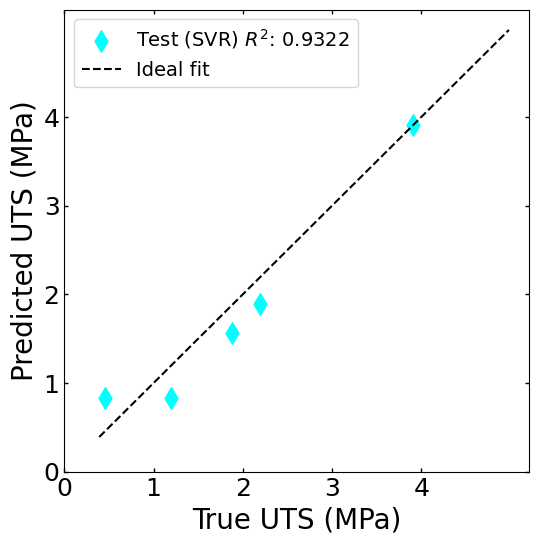

In [30]:
mean_preds_test = np.mean(np.vstack(test_preds_history), axis=0)
X_test, y_test = aggregate_predictions(mean_preds_test, test_samples_id, true_labels_test)
svr_test_preds = meta_learner.predict(X_test)

mse_test_svr = mean_squared_error(y_test, svr_test_preds)
r2_test_svr = r2_score(y_test, svr_test_preds)
print(f"Test MSE: {mse_test_svr:.4f}, R-squared: {r2_test_svr:.4f}")
# Plotting the parity plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(y_test, svr_test_preds, s=120, marker='d', color='cyan', label=f'Test (SVR) $R^2$: {r2_test_svr:.4f}')
ax.plot([true_labels_train.min(), true_labels_train.max()], [true_labels_train.min(), true_labels_train.max()], color='black', linestyle='--', label='Ideal fit')

ax.set_xlabel('True UTS (MPa)', fontsize=20)
ax.set_ylabel('Predicted UTS (MPa)', fontsize=20)
ax.tick_params(axis="x",direction="in", top=True,length=3, width=1)
ax.tick_params(axis="y",direction="in", right=True,length=3, width=1)
ax.legend(loc='upper left',prop={'size': 14})
plt.xticks(np.arange(0, 4.2, 1),fontsize=18)
plt.yticks(np.arange(0, 4.2, 1),fontsize=18)
plt.show()
fig.savefig('fig 9.jpg', dpi=1000, bbox_inches='tight', transparent=True)

RF as Meta Learner

Using device: cpu
Fold 1/5
Train MSE: 0.0612767027350433, R-squared: 0.9641601372184876
Validation MSE: 0.24393284827200726, R-squared: 0.784058363899804
Test MSE: 0.11897213837263973, R-squared: 0.9106724612834854


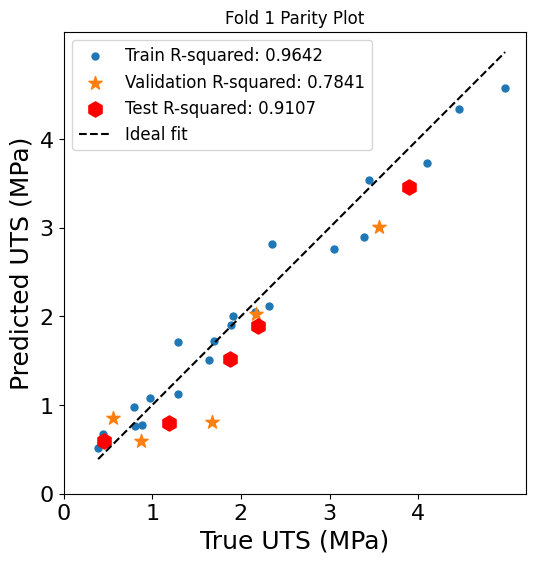

Fold 2/5
Train MSE: 0.02144832410287591, R-squared: 0.9855796479284834
Validation MSE: 0.42864376663049236, R-squared: 0.7972318495319364
Test MSE: 0.11982766383486783, R-squared: 0.9100301093438172


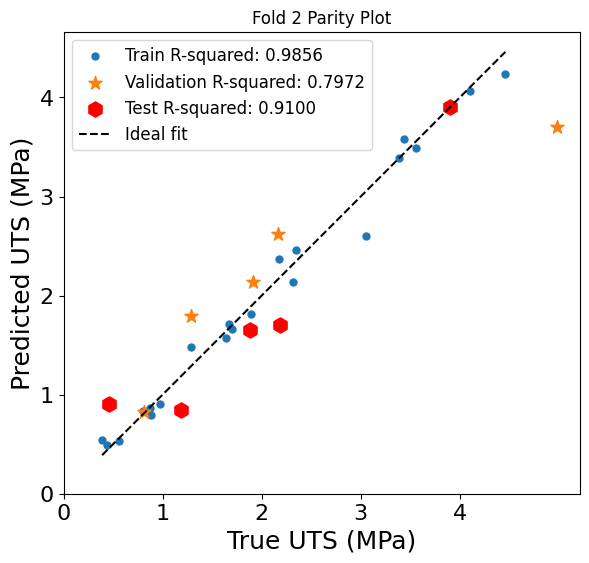

Fold 3/5
Train MSE: 0.02909363857627806, R-squared: 0.9808434810614921
Validation MSE: 0.3758586232401903, R-squared: 0.8135251950859621
Test MSE: 0.2325825525314022, R-squared: 0.825370651900357


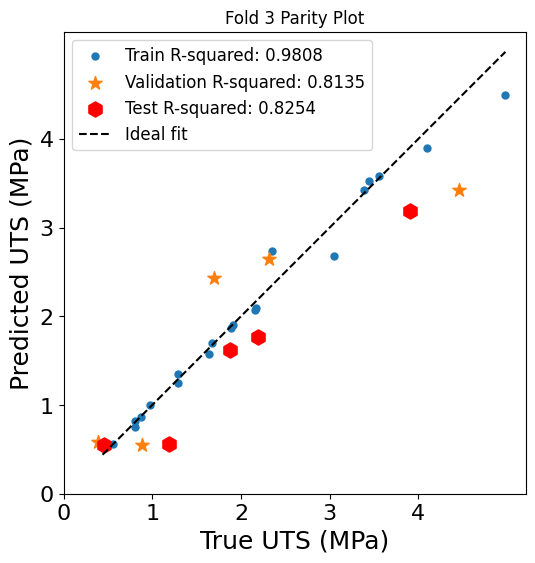

Fold 4/5
Train MSE: 0.01390433685501121, R-squared: 0.9915942853804853
Validation MSE: 0.21791080571107513, R-squared: 0.8480151501565589
Test MSE: 0.09141633520531305, R-squared: 0.9313621127259454


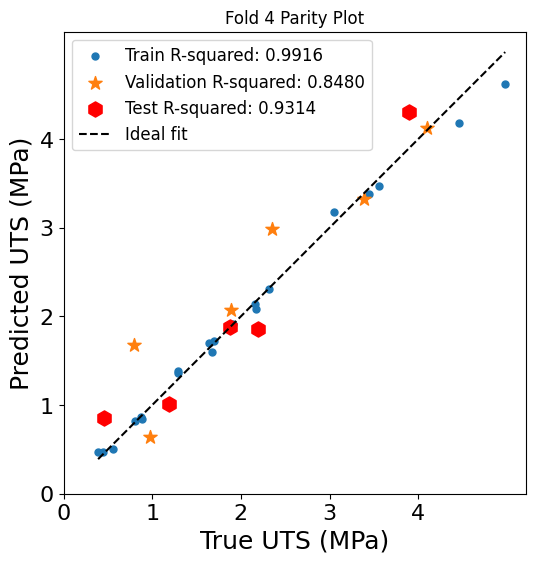

Fold 5/5
Train MSE: 0.01716777802065152, R-squared: 0.9899160677525789
Validation MSE: 0.4624405662173725, R-squared: 0.6295028460744538
Test MSE: 0.09187809788444765, R-squared: 0.9310154086642849


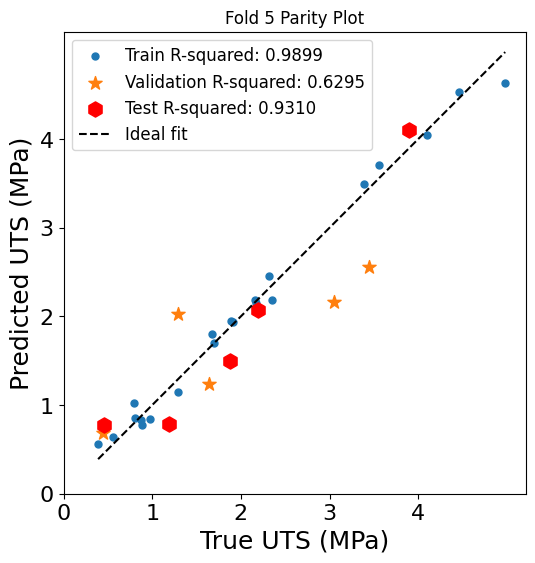

Final Statistics Across All Folds:
Train MSE: 0.0286 ± 0.0171
Train R-squared: 0.9824 ± 0.0099
Validation MSE: 0.3458 ± 0.0981
Validation R-squared: 0.7745 ± 0.0756
Test MSE: 0.1309 ± 0.0523
Test R-squared: 0.9017 ± 0.0393


In [39]:
import torch
import numpy as np
import random
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedGroupKFold
import os
import tqdm
from torchvision import transforms

# Set seeds for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

# Check if CUDA (GPU) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Data transformation and normalization
val_xform_list = [transforms.CenterCrop(224)]
params = {}
params['use_contrast'] = False
if params['use_contrast']:
    val_xform_list.append(transforms.RandomAutocontrast(p=1.0))
val_xform_list.append(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
offline_transforms = transforms.Compose(val_xform_list)

# Initialize lists to store R-squared and MSE for each fold
train_rsquared_all_fold = []
val_rsquared_all_fold = []
test_rsquared_all_fold = []

train_mse_all_fold = []
val_mse_all_fold = []
test_mse_all_fold = []

# Initialize KFold object
n_splits = 5
kf = StratifiedGroupKFold(n_splits=n_splits)

# Prepare directories for saving predictions
output_dir = '/content/drive/MyDrive/Colab Notebooks/resnet18-v5-finetune/Saved_Output'
os.makedirs(output_dir, exist_ok=True)

# Initialize the RF meta-learner
meta_learner = RandomForestRegressor(n_estimators=100, random_state=42)

# Iterate over the folds
uts_label = [it[1][0] for it in train_val_dataset]  # Record the UTS chunk
sample_id = [it[1][1] for it in train_val_dataset]  # Record the sample

for fold, (train_index, val_index) in enumerate(kf.split(train_val_dataset, y=uts_label, groups=sample_id)):
    print(f"Fold {fold + 1}/{n_splits}")
    set_seed(42)

    # Prepare file names for saving predictions
    output_train_file = os.path.join(output_dir, f'preds_train_fold{fold + 1}.npy')
    output_val_file = os.path.join(output_dir, f'preds_val_fold{fold + 1}.npy')
    output_test_file = os.path.join(output_dir, f'preds_test_fold{fold + 1}.npy')

    if os.path.exists(output_train_file) and os.path.exists(output_val_file) and os.path.exists(output_test_file):
        preds_train = np.load(output_train_file)
        true_labels_train = np.load(output_train_file.replace('preds', 'true_labels'))
        preds_val = np.load(output_val_file)
        true_labels_val = np.load(output_val_file.replace('preds', 'true_labels'))
        preds_test = np.load(output_test_file)
        true_labels_test = np.load(output_test_file.replace('preds', 'true_labels'))

        # Load sample IDs for training, validation, and test sets
        train_samples_id = np.load(output_train_file.replace('preds', 'sample_ids'))
        val_samples_id = np.load(output_val_file.replace('preds', 'sample_ids'))
        test_samples_id = np.load(output_test_file.replace('preds', 'sample_ids'))

        # === Meta-Learner Training on Aggregated Data === #
        def aggregate_predictions(preds, sample_ids, true_labels):
            unique_samples = np.unique(sample_ids)
            X_agg = []
            y_agg = []

            for sample in unique_samples:
                sample_indices = np.where(sample_ids == sample)
                # Keep all 100 prediction values for this sample as the input (flatten them)
                aggregated_preds = preds[sample_indices].flatten()  # Flatten into a 1D array
                X_agg.append(aggregated_preds)
                # Get the unique true label for this sample
                y_agg.append(true_labels[sample_indices][0])

            return np.array(X_agg), np.array(y_agg)

        # Aggregate predictions for train, validation, and test sets
        X_train, y_train = aggregate_predictions(preds_train, train_samples_id, true_labels_train)
        X_val, y_val = aggregate_predictions(preds_val, val_samples_id, true_labels_val)
        X_test, y_test = aggregate_predictions(preds_test, test_samples_id, true_labels_test)

        # Train the SVR meta-learner on the aggregated train data
        meta_learner.fit(X_train, y_train)

        # Predict with the meta-learner on the validation and test sets
        train_preds = meta_learner.predict(X_train)
        val_preds = meta_learner.predict(X_val)
        test_preds = meta_learner.predict(X_test)

        # Calculate metrics on validation and test data
        r_squared_train = r2_score(y_train, train_preds)
        mse_train = mean_squared_error(y_train, train_preds)
        r_squared_val = r2_score(y_val, val_preds)
        mse_val = mean_squared_error(y_val, val_preds)
        r_squared_test = r2_score(y_test, test_preds)
        mse_test = mean_squared_error(y_test, test_preds)
        print(f'Train MSE: {mse_train}, R-squared: {r_squared_train}')
        print(f'Validation MSE: {mse_val}, R-squared: {r_squared_val}')
        print(f'Test MSE: {mse_test}, R-squared: {r_squared_test}')

        # Store the R-squared and MSE for each fold
        train_rsquared_all_fold.append(r_squared_train)
        train_mse_all_fold.append(mse_train)
        val_rsquared_all_fold.append(r_squared_val)
        val_mse_all_fold.append(mse_val)
        test_rsquared_all_fold.append(r_squared_test)
        test_mse_all_fold.append(mse_test)

        # Plotting the parity plot
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.scatter(y_train, train_preds, s=100, marker='.', label=f'Train R-squared: {r_squared_train:.4f}')
        ax.scatter(y_val, val_preds, s=100, marker='*', label=f'Validation R-squared: {r_squared_val:.4f}')
        ax.scatter(y_test, test_preds, s=120, marker='h', color='red', label=f'Test R-squared: {r_squared_test:.4f}')
        ax.plot([true_labels_train.min(), true_labels_train.max()], [true_labels_train.min(), true_labels_train.max()], color='black', linestyle='--', label='Ideal fit')
        ax.set_xlabel('True UTS (MPa)',fontsize=18)
        ax.set_ylabel('Predicted UTS (MPa)',fontsize=18)
        ax.set_aspect('equal')
        ax.set_title(f'Fold {fold+1} Parity Plot')
        ax.legend(loc='upper left',prop={'size': 12})
        plt.xticks(np.arange(0, 4.2, 1),fontsize=16)
        plt.yticks(np.arange(0, 4.2, 1),fontsize=16)
        plt.show()
        fig.savefig(f'fig 7(a){fold+1}.jpg', dpi=1000, bbox_inches='tight', transparent=True)

    else:
        print("No Pre-Saved Data for this fold.")

# Final statistics across all folds
print("Final Statistics Across All Folds:")
print(f"Train MSE: {np.mean(train_mse_all_fold):.4f} ± {np.std(train_mse_all_fold):.4f}")
print(f"Train R-squared: {np.mean(train_rsquared_all_fold):.4f} ± {np.std(train_rsquared_all_fold):.4f}")
print(f"Validation MSE: {np.mean(val_mse_all_fold):.4f} ± {np.std(val_mse_all_fold):.4f}")
print(f"Validation R-squared: {np.mean(val_rsquared_all_fold):.4f} ± {np.std(val_rsquared_all_fold):.4f}")
print(f"Test MSE: {np.mean(test_mse_all_fold):.4f} ± {np.std(test_mse_all_fold):.4f}")
print(f"Test R-squared: {np.mean(test_rsquared_all_fold):.4f} ± {np.std(test_rsquared_all_fold):.4f}")

meta_learner_results['RF'] = {'MSE':{'Train':[np.mean(train_mse_all_fold), np.std(train_mse_all_fold)],
                                  'Validation': [np.mean(val_mse_all_fold), np.std(val_mse_all_fold)],
                                  'Test':[np.mean(test_mse_all_fold),np.std(test_mse_all_fold)]},
                           'R2':{'Train':[np.mean(train_rsquared_all_fold), np.std(train_rsquared_all_fold)],
                                  'Validation': [np.mean(val_rsquared_all_fold), np.std(val_rsquared_all_fold)],
                                  'Test':[np.mean(test_rsquared_all_fold),np.std(test_rsquared_all_fold)]}}


Ensmeble + RF meta-learner

Test MSE: 0.1305, R-squared: 0.9020


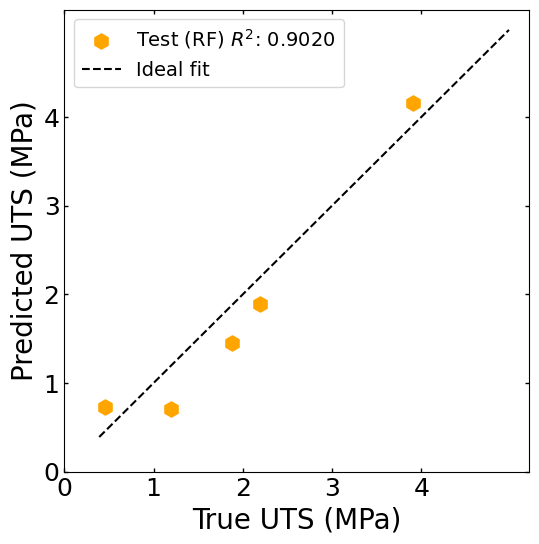

In [40]:
mean_preds_test = np.mean(np.vstack(test_preds_history), axis=0)
X_test, y_test = aggregate_predictions(mean_preds_test, test_samples_id, true_labels_test)
rf_test_preds = meta_learner.predict(X_test)

mse_test_rf = mean_squared_error(y_test, rf_test_preds)
r2_test_rf = r2_score(y_test, rf_test_preds)
print(f"Test MSE: {mse_test_rf:.4f}, R-squared: {r2_test_rf:.4f}")
# Plotting the parity plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(y_test, rf_test_preds, s=120, marker='h', color='orange', label=f'Test (RF) $R^2$: {r2_test_rf:.4f}')
ax.plot([true_labels_train.min(), true_labels_train.max()], [true_labels_train.min(), true_labels_train.max()], color='black', linestyle='--', label='Ideal fit')

ax.set_xlabel('True UTS (MPa)', fontsize=20)
ax.set_ylabel('Predicted UTS (MPa)', fontsize=20)
ax.tick_params(axis="x",direction="in", top=True,length=3, width=1)
ax.tick_params(axis="y",direction="in", right=True,length=3, width=1)
ax.legend(loc='upper left',prop={'size': 14})
plt.xticks(np.arange(0, 4.2, 1),fontsize=18)
plt.yticks(np.arange(0, 4.2, 1),fontsize=18)
plt.show()
fig.savefig('fig 9.jpg', dpi=1000, bbox_inches='tight', transparent=True)

In [41]:
meta_learner_results.keys()

dict_keys(['Without', 'Mean', 'Median', 'Linear', 'SVR', 'RF'])

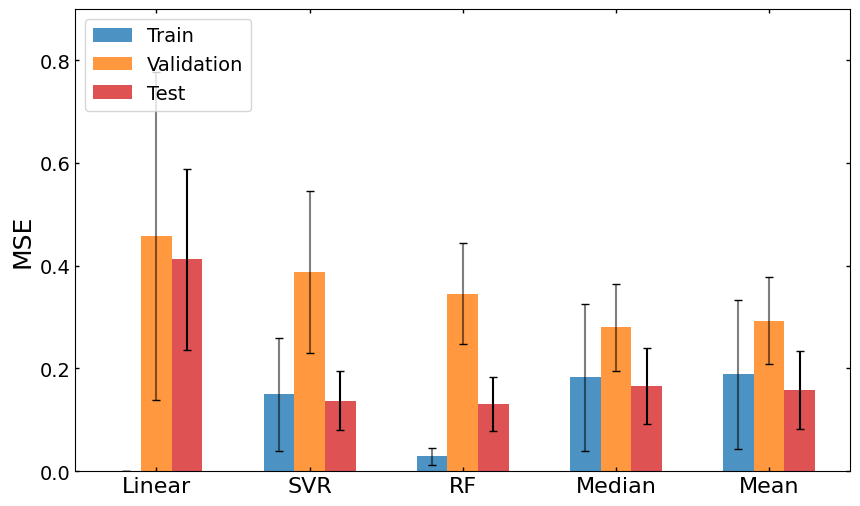

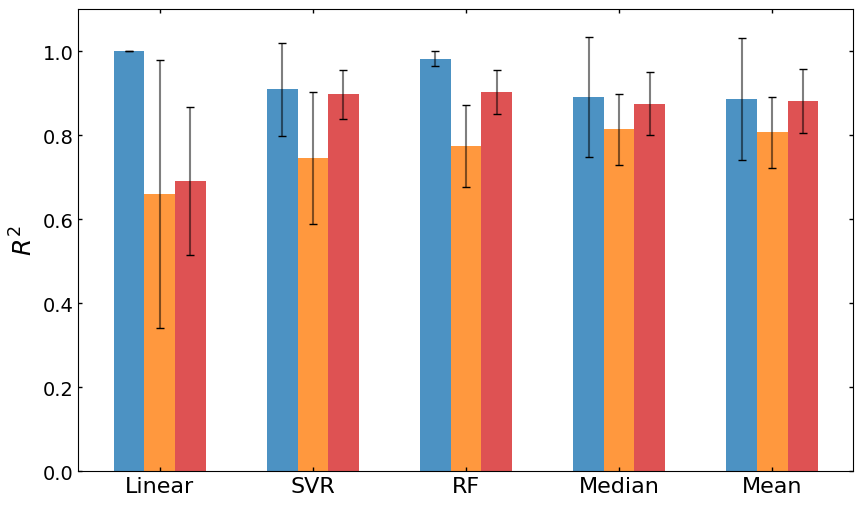

In [42]:
import numpy as np
import matplotlib.pyplot as plt

models = ['Linear','SVR','RF','Median','Mean']

# Extract MSE and R² values and their standard deviations
mse_values = {
    'Train': [meta_learner_results[m]['MSE']['Train'][0] for m in models],
    'Validation': [meta_learner_results[m]['MSE']['Validation'][0] for m in models],
    'Test': [meta_learner_results[m]['MSE']['Test'][0] for m in models]
}

mse_values_std = {
    'Train': [meta_learner_results[m]['MSE']['Train'][1] for m in models],
    'Validation': [meta_learner_results[m]['MSE']['Validation'][1] for m in models],
    'Test': [meta_learner_results[m]['MSE']['Test'][1] for m in models]
}

r2_values = {
    'Train': [meta_learner_results[m]['R2']['Train'][0] for m in models],
    'Validation': [meta_learner_results[m]['R2']['Validation'][0] for m in models],
    'Test': [meta_learner_results[m]['R2']['Test'][0] for m in models]
}

r2_values_std = {
    'Train': [meta_learner_results[m]['R2']['Train'][1] for m in models],
    'Validation': [meta_learner_results[m]['R2']['Validation'][1] for m in models],
    'Test': [meta_learner_results[m]['R2']['Test'][1] for m in models]
}


x = np.arange(len(models))  # label locations
width = 0.2  # bar width

# Plot MSE with error bars
fig1, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width, mse_values['Train'], width, yerr=mse_values_std['Train'], label='Train', color='tab:blue', capsize=3, alpha=0.8)
bars2 = ax.bar(x, mse_values['Validation'], width, yerr=mse_values_std['Validation'], label='Validation', color='tab:orange', capsize=3, alpha=0.8)
bars3 = ax.bar(x + width, mse_values['Test'], width, yerr=mse_values_std['Test'], label='Test', color='tab:red', capsize=3, alpha=0.8)

# # Access the error bars directly and make them more transparent
for bar in bars1.errorbar.lines[2]:
    bar.set_alpha(0.5)  # Adjust the alpha for Train error bars
for bar in bars2.errorbar.lines[2]:
    bar.set_alpha(0.5)  # Adjust the alpha for Validation error bars


ax.set_ylabel('MSE', fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=14)
ax.legend(loc='upper left',prop={'size': 14})

ax.tick_params(axis="x",direction="in", top=True,length=3, width=1)
ax.tick_params(axis="y",direction="in", right=True,length=3, width=1)

plt.xticks(fontsize=16)
plt.yticks(np.arange(0, 0.9, 0.2),fontsize=14)
ax.set_ylim([0, 0.9])
plt.show()

# Plot R-squared with error bars
fig2, ax = plt.subplots(figsize=(10, 6))
# ax.bar(x - width, r2_values['Train'], width, yerr=r2_values_std['Train'], label='Train', color='green', capsize=3)
# ax.bar(x, r2_values['Validation'], width, yerr=r2_values_std['Validation'], label='Validation', color='red', capsize=3)
bars1 = ax.bar(x - width, r2_values['Train'], width, yerr=mse_values_std['Train'], label='Train', color='tab:blue', capsize=3, alpha=0.8)
bars2 = ax.bar(x, r2_values['Validation'], width, yerr=mse_values_std['Validation'],
               label='Validation', color='tab:orange', capsize=3, alpha=0.8)
bars3 = ax.bar(x + width, r2_values['Test'], width, yerr=mse_values_std['Test'], label='Test', color='tab:red', capsize=3, alpha=0.8)

# Access the error bars directly and make them more transparent
for bar in bars1.errorbar.lines[2]:
    bar.set_alpha(0.5)  # Adjust the alpha for Train error bars
for bar in bars2.errorbar.lines[2]:
    bar.set_alpha(0.5)  # Adjust the alpha for Validation error bars
for bar in bars3.errorbar.lines[2]:
    bar.set_alpha(0.5)  # Adjust the alpha for Validation error bars


ax.set_ylabel(r'$R^2$', fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=14)
# ax.legend(loc='upper left',prop={'size': 14})

ax.tick_params(axis="x",direction="in", top=True,length=3, width=1)
ax.tick_params(axis="y",direction="in", right=True,length=3, width=1)

plt.xticks(fontsize=16)
plt.yticks(np.arange(0, 1.1, 0.2),fontsize=14)
ax.set_ylim([0, 1.1])
plt.show()

# PCA

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import joblib
from torch.utils.data import DataLoader, Subset
from PIL import Image
from sklearn.model_selection import KFold
import random
import torch.nn as nn
import torchvision.transforms as transforms

# Set seeds for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

val_xform_list = [transforms.CenterCrop(224)]
params={}
params['use_contrast'] = False
if params['use_contrast']:
    val_xform_list.append(transforms.RandomAutocontrast(p=1.0))
val_xform_list.append(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
offline_transforms = transforms.Compose(val_xform_list)

# Storage for all folds
all_pca_data = []
all_outliers_data = []
# Initialize KFold object
n_splits = 5
kf = StratifiedGroupKFold(n_splits=n_splits)

# Iterate over the folds
uts_label = [it[1][0] for it in train_val_dataset]  # record the UTS chunk # when making the dataset
sample_id = [it[1][1] for it in train_val_dataset]  # record the sample # when making the dataset

for fold, (train_index, val_index) in enumerate(kf.split(train_val_dataset, y=uts_label, groups=sample_id)):
    print(f"Fold {fold+1}/{n_splits}")
    set_seed(42)

    # Create train and validation datasets for this fold
    train_dataset = Subset(train_val_dataset, train_index)
    val_dataset = Subset(train_val_dataset, val_index)

    # Create train and validation loaders for this fold
    train_loader = DataLoader(
        train_dataset, batch_size=128, shuffle=False, worker_init_fn=seed_worker)
    val_loader = DataLoader(
        val_dataset, batch_size=128, shuffle=False, worker_init_fn=seed_worker)
    test_loader = DataLoader(
        test_dataset, batch_size=128, shuffle=False, worker_init_fn=seed_worker)

    # Load the model and create new_model with the same dimension as the original model's penultimate layer
    model = torch.load(f'/content/drive/MyDrive/Colab Notebooks/resnet18-v5-finetune/resnet18-v5-fold{fold+1}.pth', weights_only=False,map_location=device)
    new_model = nn.Sequential(*list(model.children())[:-1])  # Remove the last layer
    model.to(device)
    model.eval()
    new_model.to(device)
    new_model.eval()

    # Get the dimension of the last layer of new_model
    last_layer_dim = 512
    # Create lists to store the features and labels
    preds_train, latent_train, features_train, labels_train = [], [], [], []
    preds_val, latent_val, features_val, labels_val = [], [], [], []
    preds_test, latent_test, features_test, labels_test = [], [], [], []

    with torch.no_grad():
        # Extract features for train set
        for images, group, labels, features in train_loader:
            images = offline_transforms(images)
            outputs = model(images)         # Get predictions from the original model
            new_outputs = new_model(images) # Get features from new_model
            preds_train.append(outputs.cpu().numpy())
            latent_train.append(new_outputs.cpu().numpy())
            features_train.append(features.cpu().numpy())
            labels_train.append(labels.cpu().numpy())

        # Extract features for validation set
        for images, group, labels, features in val_loader:
            images = offline_transforms(images)
            outputs = model(images)
            new_outputs = new_model(images)
            preds_val.append(outputs.cpu().numpy())
            latent_val.append(new_outputs.cpu().numpy())
            features_val.append(features.cpu().numpy())
            labels_val.append(labels.cpu().numpy())

        # Extract features for test set
        for images, group, labels, features in test_loader:
            images = offline_transforms(images)
            outputs = model(images)         # Get predictions from the original model
            new_outputs = new_model(images) # Get features from new_model
            preds_test.append(outputs.cpu().numpy())
            latent_test.append(new_outputs.cpu().numpy())
            features_test.append(features.cpu().numpy())
            labels_test.append(labels.cpu().numpy())

    # Convert to numpy arrays
    latent_train = np.vstack(latent_train)
    latent_train = latent_train.reshape(latent_train.shape[:2])
    features_train = np.vstack(features_train)
    preds_train = np.vstack(preds_train)
    labels_train = np.hstack(labels_train)

    latent_val = np.vstack(latent_val)
    latent_val = latent_val.reshape(latent_val.shape[:2])
    features_val = np.vstack(features_val)
    preds_val = np.vstack(preds_val)
    labels_val = np.hstack(labels_val)

    latent_test = np.vstack(latent_test)
    latent_test = latent_test.reshape(latent_test.shape[:2])
    features_test = np.vstack(features_test)
    preds_test = np.vstack(preds_test)
    labels_test = np.hstack(labels_test)

    # Combine all latent representations before PCA
    combined_latent = np.vstack([latent_train, latent_val, latent_test])

    # Apply PCA to reduce the dimensions to 10 components on the combined data
    pca = PCA(n_components=10)
    combined_pca_features = pca.fit_transform(combined_latent)

    # Split the transformed data back into train, val, and test sets
    pca_features_train = combined_pca_features[:len(latent_train)]
    pca_features_val = combined_pca_features[len(latent_train):len(latent_train) + len(latent_val)]
    pca_features_test = combined_pca_features[len(latent_train) + len(latent_val):]

    # Identify outliers for each dataset separately
    high_value_indices_train = np.where(preds_train > 6)[0]
    high_value_indices_val = np.where(preds_val > 6)[0]
    high_value_indices_test = np.where(preds_test > 6)[0]

    # Find the correct PCA feature ranges for outliers
    outliers_train_indices = np.repeat(high_value_indices_train, last_layer_dim)
    outliers_val_indices = np.repeat(high_value_indices_val, last_layer_dim)
    outliers_test_indices = np.repeat(high_value_indices_test, last_layer_dim)

    # Extract outliers by mapping indices
    outliers_train = pca_features_train[high_value_indices_train]
    outliers_val = pca_features_val[high_value_indices_val]
    outliers_test = pca_features_test[high_value_indices_test]

    # Store the outlier features corresponding to the outlier PCA results
    outliers_features_train = features_train[high_value_indices_train]
    outliers_features_val = features_val[high_value_indices_val]
    outliers_features_test = features_test[high_value_indices_test]

    # Store the PCA results for later plotting
    all_pca_data.append({
        'pca': pca,
        'pca_features_train': pca_features_train,
        'pca_features_val': pca_features_val,
        'pca_features_test': pca_features_test,
        'features_train': features_train,
        'features_val': features_val,
        'features_test': features_test,
    })

    all_outliers_data.append({
        'pca': pca,
        'pca_features_train': outliers_train,
        'pca_features_val': outliers_val,
        'pca_features_test': outliers_test,
        'features_train': outliers_features_train,
        'features_val': outliers_features_val,
        'features_test': outliers_features_test,
    })

# Save all the PCA results and data for future use
joblib.dump(all_pca_data, '/content/drive/MyDrive/pca_data.pkl')
joblib.dump(all_outliers_data, '/content/drive/MyDrive/pca_data_outliers.pkl')


Using device: cuda
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


['/content/drive/MyDrive/pca_data_outliers.pkl']

In [43]:
import joblib
import matplotlib.pyplot as plt

# Load the saved PCA data
all_pca_data = joblib.load('/content/drive/MyDrive/pca_data.pkl')
all_outliers_data = joblib.load('/content/drive/MyDrive/pca_data_outliers.pkl')

# Iterate over the saved PCA results for each fold
for fold, (data, outliers_data) in enumerate(zip(all_pca_data, all_outliers_data)):
    pca = data['pca']
    pca_features_train = data['pca_features_train']
    pca_features_val = data['pca_features_val']
    pca_features_test = data['pca_features_test']
    features_train = data['features_train']
    features_val = data['features_val']
    features_test = data['features_test']

    outliers_train = outliers_data['pca_features_train']
    outliers_val = outliers_data['pca_features_val']
    outliers_test = outliers_data['pca_features_test']

    figsize=(6, 6)

    # Plot Explained Variance
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(range(1, 11), pca.explained_variance_ratio_, alpha=0.7, color='b', align='center')
    ax.set_title(f'Explained Variance by Principal Components - Fold {fold+1}')
    ax.set_xlabel('Principal Component', fontsize=14)
    ax.set_ylabel('Explained Variance Ratio', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

    fig, ax = plt.subplots(figsize=figsize)
    _ = ax.plot(np.arange(1, 11), np.cumsum(pca.explained_variance_ratio_[:10]), '.-')
    _ = ax.set_xlabel('Components', fontsize=14)
    _ = ax.set_ylabel('Explained Variance', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Plot for 'True UTS (MPa)'
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.scatter(pca_features_train[:, 0], pca_features_train[:, 1], c=features_train[:, -3], s=20, cmap='viridis', label='Train')
    ax.scatter(pca_features_val[:, 0], pca_features_val[:, 1], c=features_val[:, -3], s=20, cmap='viridis', marker='*', label='Validation')
    ax.scatter(pca_features_test[:, 0], pca_features_test[:, 1], c=features_test[:, -3], s=20, cmap='viridis', marker='x', label='Test')

    # Plot outliers in red
    # ax.scatter(outliers_train[:, 0], outliers_train[:, 1], c='red', s=20, label='Outliers')

    cb = plt.colorbar(im)
    cb.set_label('True UTS (MPa)', fontsize=12)
    cb.ax.tick_params(labelsize=12)

    ax.set_xlabel('Principal Component 1', fontsize=14)
    ax.set_ylabel('Principal Component 2', fontsize=14)
    ax.set_title(f'Fold {fold+1}', fontsize=16)
    ax.legend()
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.scatter(pca_features_train[:, 0], pca_features_train[:, 1], c=features_train[:, 2], s=20, vmin=40, vmax=500, cmap='viridis', label='Train')
    ax.scatter(pca_features_val[:, 0], pca_features_val[:, 1], c=features_val[:, 2], s=20, cmap='viridis', marker='*', label='Validation')
    ax.scatter(pca_features_test[:, 0], pca_features_test[:, 1], c=features_test[:, 2], s=20, cmap='viridis', marker='x', label='Test')

    # Plot outliers in red
    # ax.scatter(outliers_train[:, 0], outliers_train[:, 1], c='red', s=20, label='Outliers')

    cb = plt.colorbar(im)
    cb.set_label('$\mathregular{CaSO_4}$ domain thickness (µm)', fontsize=12)
    cb.ax.tick_params(labelsize=12)

    ax.set_xlabel('Principal Component 1', fontsize=14)
    ax.set_ylabel('Principal Component 2', fontsize=14)
    ax.set_title(f'Fold {fold+1}', fontsize=16)
    ax.legend()
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.scatter(pca_features_train[:, 0], pca_features_train[:, 1], c=features_train[:, 3], s=20,vmin=10, vmax=50, cmap='viridis', label='Train')
    ax.scatter(pca_features_val[:, 0], pca_features_val[:, 1], c=features_val[:, 3], s=20, cmap='viridis', marker='*', label='Validation')
    ax.scatter(pca_features_test[:, 0], pca_features_test[:, 1], c=features_test[:, 3], s=20, cmap='viridis', marker='x', label='Test')

    # Plot outliers in red
    # ax.scatter(outliers_train[:, 0], outliers_train[:, 1], c='red', s=20, label='Outliers')

    cb = plt.colorbar(im)
    cb.set_label('STD of $\mathregular{CaSO_4}$ domain thickness (µm)', fontsize=12)
    cb.ax.tick_params(labelsize=12)

    ax.set_xlabel('Principal Component 1', fontsize=14)
    ax.set_ylabel('Principal Component 2', fontsize=14)
    ax.set_title(f'Fold {fold+1}', fontsize=16)
    ax.legend()
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.scatter(pca_features_train[:, 0], pca_features_train[:, 1], c=features_train[:, 4], s=20, vmin=10, vmax=70, cmap='viridis', label='Train')
    ax.scatter(pca_features_val[:, 0], pca_features_val[:, 1], c=features_val[:, 4], s=20, cmap='viridis', marker='*', label='Validation')
    ax.scatter(pca_features_test[:, 0], pca_features_test[:, 1], c=features_test[:, 4], s=20, cmap='viridis', marker='x', label='Test')

    # Plot outliers in red
    # ax.scatter(outliers_train[:, 0], outliers_train[:, 1], c='red', s=20, label='Outliers')

    cb = plt.colorbar(im)
    cb.set_label('Polymer fraction (%)', fontsize=12)
    cb.ax.tick_params(labelsize=12)

    ax.set_xlabel('Principal Component 1', fontsize=14)
    ax.set_ylabel('Principal Component 2', fontsize=14)
    ax.set_title(f'Fold {fold+1}', fontsize=16)
    ax.legend()
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.scatter(pca_features_train[:, 0], pca_features_train[:, 1], c=features_train[:, 6], s=20, vmin=-2, vmax=4,cmap='viridis', label='Train')
    ax.scatter(pca_features_val[:, 0], pca_features_val[:, 1], c=features_val[:, 6], s=20, cmap='viridis', marker='*', label='Validation')
    ax.scatter(pca_features_test[:, 0], pca_features_test[:, 1], c=features_test[:, 6], s=20, cmap='viridis', marker='x', label='Test')

    # Plot outliers in red
    # ax.scatter(outliers_train[:, 0], outliers_train[:, 1], c='red', s=20, label='Outliers')

    cb = plt.colorbar(im)
    cb.set_label('Skewness of $\mathregular{CaSO_4}$ domain thickness (µm)', fontsize=12)
    cb.ax.tick_params(labelsize=12)

    ax.set_xlabel('Principal Component 1', fontsize=14)
    ax.set_ylabel('Principal Component 2', fontsize=14)
    ax.set_title(f'Fold {fold+1}', fontsize=16)
    ax.legend()
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.scatter(pca_features_train[:, 0], pca_features_train[:, 1], c=features_train[:, 7], s=20, vmin=0, vmax=6,cmap='viridis', label='Train')
    ax.scatter(pca_features_val[:, 0], pca_features_val[:, 1], c=features_val[:, 7], s=20, cmap='viridis', marker='*', label='Validation')
    ax.scatter(pca_features_test[:, 0], pca_features_test[:, 1], c=features_test[:, 7], s=20, cmap='viridis', marker='x', label='Test')

    # Plot outliers in red
    # ax.scatter(outliers_train[:, 0], outliers_train[:, 1], c='red', s=20, label='Outliers')

    cb = plt.colorbar(im)
    cb.set_label('Kurtosis of $\mathregular{CaSO_4}$ domain thickness (µm)', fontsize=12)
    cb.ax.tick_params(labelsize=12)

    ax.set_xlabel('Principal Component 1', fontsize=14)
    ax.set_ylabel('Principal Component 2', fontsize=14)
    ax.set_title(f'Fold {fold+1}', fontsize=16)
    ax.legend()
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()



Output hidden; open in https://colab.research.google.com to view.